## Classification of fixed size paragraph vectors using standard nn
should be able to deal with all levels using the PARTS_LEVEL param

In [3]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.pooling import GlobalAveragePooling1D

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Global variables used throughout the script

In [4]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [5]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [6]:
NUM_CORES = 16

In [7]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"

In [9]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [10]:
SAMPLE_RATIO = 0.15

In [11]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

doc_vec_types = "extended_abs_desc_claims_large_sample_chunks"
doc_vec_preprocessed_data_types = "extended_pv_abs_desc_claims_large_sample_chunks"

exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(big_data_location, "parameter_search_doc2vec_models_" + doc_vec_types, "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_" + doc_vec_types)
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
# training_docs_list_file = exports_location + "extended_pv_training_docs_list.pkl"
# validation_docs_list_file = exports_location + "extended_pv_validation_docs_list.pkl"
# test_docs_list_file = exports_location + "extended_pv_test_docs_list.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"

preprocessed_location = os.path.join(big_data_location, "preprocessed_data", doc_vec_preprocessed_data_types) + "/"

training_preprocessed_files_prefix = preprocessed_location + "extended_pv_training_docs_data_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "extended_pv_validation_docs_data_preprocessed-"
test_preprocessed_files_prefix = preprocessed_location + "extended_pv_test_docs_data_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

# Load general data required for classification

In [12]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 19 s, sys: 2.44 s, total: 21.4 s
Wall time: 21.5 s


In [13]:
len(training_docs_list)

254767

In [14]:
len(validation_docs_list)

60957

In [15]:
len(test_docs_list)

79785

In [16]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

# Utility Functions for data loading

In [17]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector


In [18]:
class FixedDocumentsStatsGenerator(object):
    def __init__(self, filename_prefix):
        self.filename_prefix = filename_prefix
        self.docids = []
        self.doc_parts = defaultdict(list)
        self.doc_part_chunks = defaultdict(list)
        self.curr_doc_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        info("Loading new batch for index: {}".format(self.curr_doc_index))
        true_docs_count = 0
        try:
            with open(self.filename_prefix + str(self.curr_doc_index)) as preproc_file:
                for line in preproc_file:
                    line_array = line.split(" ", 1)
                    entity_id = line_array[0].strip()
                    if self.is_doc(entity_id):
                        self.docids.append(entity_id)
                        true_docs_count+= 1
                    elif self.is_doc_part(entity_id):
                        self.doc_parts[self.get_doc_id(entity_id)].append(entity_id)
                    elif self.is_doc_part_chunk(entity_id):
                        self.doc_part_chunks[self.get_doc_id(entity_id)].append(entity_id)
            self.batch_end = self.curr_doc_index + true_docs_count - 1 
            info("Finished loading new batch of {} documents".format(true_docs_count))
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_doc_index))
            raise StopIteration()
    def get_stats(self):
        try:
            while True:
                if self.curr_doc_index > self.batch_end:
                    self.load_new_batch_in_memory()
                self.curr_doc_index = self.batch_end + 1
        except StopIteration:
            pass
            
    def get_doc_id(self, entity_id):
        return entity_id.split("_")[0]
    def get_entity_parts(self, entity_id):
        return entity_id.split("_")
    def is_doc(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 1:
            return True
        return False
    def is_doc_part(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 2:
            return True
        return False
    def is_doc_part_chunk(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 3:
            return True
        return False

In [19]:
def get_doc_vector(entity_id):
    if entity_id in doc2vec_model.docvecs:
        if DOC2VEC_MMAP:
            normal_array = []
            normal_array[:] = doc2vec_model.docvecs[entity_id][:]
            return normal_array
        else:
            return doc2vec_model.docvecs[entity_id]
    else:
        # some claims have low token count, so they cant fill out the whole 16 spots
        return ZERO_VECTOR

def data_generator(doc_stats, doc_id):
    yield get_doc_vector(doc_id)
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield get_doc_vector(part_id)
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield get_doc_vector(part_id)
    yield ZERO_VECTOR

def validation_data_generator(doc_stats, validation_dict, doc_id):
    yield validation_dict[doc_id]
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield validation_dict[part_id]
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield validation_dict[part_id]
    yield ZERO_VECTOR
        

In [20]:
def get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for training
    """
    def get_training_y_labels():
        """
        Creates or loads the y matrix used for training
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_LABELS_MATRIX.format(classifications_type))):
            info("Creating Training Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(training_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            training_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                            TRAINING_LABELS_MATRIX.format(classifications_type))))
        return training_labels_mat

    
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Training Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        training_data = np.ndarray((len(training_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Training Data shape: {}".format(training_data.shape))
        training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(training_docs_list):
            data_gen = data_generator(doc_stats, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3rd level: feature vectors
                training_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in training".format(i))
        
        info("Saving Training Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL)), "w"), training_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_LABELS_MATRIX.format(classifications_type)), "w"), training_labels_mat)
    else:
        info("Loading Training Data from file")
        training_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL))))
        training_labels_mat = get_training_y_labels()
        
    return training_data, training_labels_mat

In [23]:
def get_validation_data(validation_dict, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for validation
    """
    def get_validation_y_labels():
        """
        Creates or loads the y matrix used for validation
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_LABELS_MATRIX.format(classifications_type))):
            info("Creating Validation Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(validation_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            info("Loading Validation Labels")
            validation_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                        VALIDATION_LABELS_MATRIX.format(classifications_type))))
        return validation_labels_mat

    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Validation Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        validation_data = np.ndarray((len(validation_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Validation Data shape: {}".format(validation_data.shape))
        validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(validation_docs_list):
            data_gen = validation_data_generator(doc_stats, validation_dict, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3d level: feature vectors
                validation_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in validation".format(i))
        
        info("Saving Validation Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL)), "w"), validation_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_LABELS_MATRIX.format(classifications_type)), "w"), validation_labels_mat)
    else:
        info("Loading Validation Data from file")
        validation_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))))
        validation_labels_mat = get_validation_y_labels()
        
    return validation_data, validation_labels_mat

# Set what we want to train for (classification type and level)

In [98]:
classifications = valid_subclasses
classifications_type = 'subclasses'
classifier_file = TYPE_CLASSIFIER.format(classifications_type)

#### This is where we set which level we want to train for
0 -> Use only the document vector  
1 -> Use the document vector and the vectors for abstract, description, claims  
2 -> Use the document vector and the vectors for abstract, description, claims plus the chunk vectors

In [133]:
LEVEL_DOC = 0
LEVEL_DIVISIONS = 1
LEVEL_CHUNKS = 2

PARTS_LEVEL = LEVEL_CHUNKS

# Load the Doc2vec model

In [117]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_MMAP = 'r'
# DOC2VEC_MMAP = None

ZERO_VECTOR = [0] * DOC2VEC_SIZE

In [118]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
doc2vec_model = None

training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")


print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [53]:
%%time
print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
    doc2vec_model.workers = NUM_CORES
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
else:
    info("Couldnt find the doc2vec model with epoch {}".format(epoch))
    raise Exception()

2017-03-27 23:06:26,661 : INFO : loading Doc2Vec object from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


/mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


2017-03-27 23:07:08,407 : INFO : loading docvecs recursively from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.* with mmap=r
2017-03-27 23:07:08,409 : INFO : loading doctag_syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.doctag_syn0.npy with mmap=r
2017-03-27 23:07:08,424 : INFO : loading syn1neg from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn1neg.npy with mmap=r
2017-03-27 23:07:08,435 : INFO : loading syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chun

CPU times: user 31.5 s, sys: 11 s, total: 42.5 s
Wall time: 45.2 s


# Get the Data to use for Training

#### Create/Load Training Document Stats 
these contain references to the ids of the parts of each document 

(ex. 059884 -> ["059884_abstract", "059884_abstract", "059884_abstract", "059884_abstract_part-1",...]) 

so we know what to load when constructing the training and validation matrices

In [54]:
%%time
if not os.path.exists(training_doc_stats_file):
    info("Creating Training Document Stats")
    doc_stats = FixedDocumentsStatsGenerator(training_preprocessed_files_prefix)
    doc_stats.get_stats()
    pickle.dump(doc_stats, open(training_doc_stats_file, "w"))
else:
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))

2017-03-27 23:07:11,872 : INFO : Loading Training Document Stats


CPU times: user 17.2 s, sys: 1.01 s, total: 18.2 s
Wall time: 18.2 s


### For MAX_PARTS_CHUNKS, use second line if paragraphs, use first line if chunks

In [134]:
MAX_SIZE = 1 # for document vector
if PARTS_LEVEL >= LEVEL_DIVISIONS:
    MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
    MAX_SIZE += MAX_PARTS

if PARTS_LEVEL >= LEVEL_CHUNKS:
    # MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
    MAX_PART_CHUNKS = int(np.percentile([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids], 90))
    MAX_SIZE += MAX_PART_CHUNKS
    
print "Max Size: {}".format(MAX_SIZE)

Max Size: 34


#### Get Training Data Matrices

In [135]:
%%time
X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)

2017-03-28 15:25:45,099 : INFO : Loading Training Data from file
2017-03-28 15:26:33,293 : INFO : Creating Training Labels


CPU times: user 11.3 s, sys: 24.9 s, total: 36.2 s
Wall time: 59.7 s


In [136]:
import sys
print sys.getsizeof(X)
print X.shape
print y.shape

6929662528
(254767, 34, 200)
(254767, 940)


#### Create/Load Validation Doc Stats

In [137]:
validation_dict = None

Load Validation Dict. This is the dictionary that contains the precomputed doc2vec vectors for each document, document part and chunk

In [59]:
%%time
validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))

CPU times: user 3min 3s, sys: 6.14 s, total: 3min 9s
Wall time: 3min 10s


In [60]:
%%time
if not os.path.exists(validation_doc_stats_file):
    validation_doc_stats = FixedDocumentsStatsGenerator(validation_preprocessed_files_prefix)
    validation_doc_stats.get_stats()
    pickle.dump(validation_doc_stats, open(validation_doc_stats_file, "w"))
else:
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))

2017-03-27 23:10:51,361 : INFO : Loading Validation Document Stats


CPU times: user 4.37 s, sys: 672 ms, total: 5.04 s
Wall time: 5.08 s


#### Get Validation Data Matrices

In [138]:
%%time
Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)

2017-03-28 15:27:00,523 : INFO : Loading Validation Data from file
2017-03-28 15:27:10,862 : INFO : Creating Validation Labels


CPU times: user 2.88 s, sys: 5.43 s, total: 8.31 s
Wall time: 13.2 s


In [139]:
del validation_dict

## Reshaping Training and Validation Matrices

In [140]:
print X.shape
print Xv.shape
print y.shape
print yv.shape

(254767, 34, 200)
(60957, 34, 200)
(254767, 940)
(60957, 940)


In [141]:
X = np.reshape(X, (X.shape[0], X.shape[1]* X.shape[2]))
Xv = np.reshape(Xv, (Xv.shape[0], Xv.shape[1]* Xv.shape[2]))

In [142]:
print X.shape
print Xv.shape
print y.shape
print yv.shape

(254767, 6800)
(60957, 6800)
(254767, 940)
(60957, 940)


# Actual Training

In [143]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [144]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 20,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [145]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
    GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
    GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [146]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = X.shape[1]
# NN_INPUT_NEURONS = DOC2VEC_SIZE

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 30
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 2048

MODEL_VERBOSITY = 0

to_skip = []

load_existing_results = True
save_results = True


first_hidden_layer_sizes = [100,200,500,1000]
# first_hidden_layer_sizes = [1000,2000]
# second_hidden_layer_sizes = [1000,2000,3000,4000]
second_hidden_layer_sizes = [None,500,1000,2000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False, True]
# hidden_dropout_options = [False, True]
input_dropout_options = [False]
hidden_dropout_options = [True]
second_hidden_dropout_options = [False]


np.random.seed(NN_SEED)


# # Uncomment for Specific Configuration
# NN_RANDOM_SEARCH_BUDGET = 1
# first_hidden_layer_sizes = [500]
# second_hidden_layer_sizes = [None]
# first_hidden_layer_activations = ['tanh']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [True]
# hidden_dropout_options = [True]
# second_hidden_dropout_options = [False]

2017-03-28 15:31:30,345 : INFO : Loading Previous results in /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_subclasses_level_2_batch_2048_nn_parameter_searches.pkl
2017-03-28 15:31:31,382 : INFO : ***************************************************************************************
2017-03-28 15:31:31,383 : INFO : nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_97 (Dropout)             (None, 100)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          101000      dropout_97[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


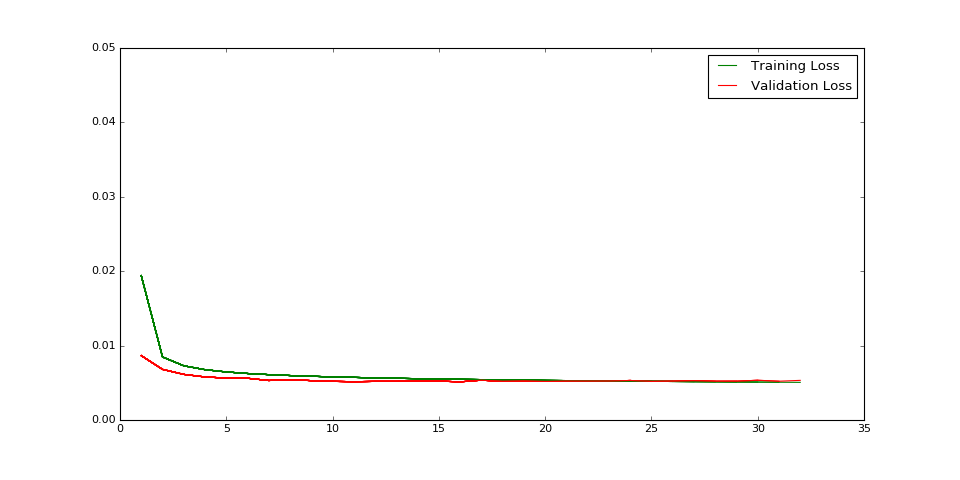

2017-03-28 15:31:44,976 : INFO : Found lower val loss for epoch 1 => 0.00865
2017-03-28 15:31:56,247 : INFO : Found lower val loss for epoch 2 => 0.0068
2017-03-28 15:32:07,645 : INFO : Found lower val loss for epoch 3 => 0.00613
2017-03-28 15:32:18,046 : INFO : Found lower val loss for epoch 4 => 0.00578
2017-03-28 15:32:28,767 : INFO : Found lower val loss for epoch 5 => 0.00564
2017-03-28 15:32:38,861 : INFO : Found lower val loss for epoch 6 => 0.00561
2017-03-28 15:32:50,272 : INFO : Found lower val loss for epoch 7 => 0.00531
2017-03-28 15:33:11,066 : INFO : Found lower val loss for epoch 9 => 0.00529
2017-03-28 15:33:21,254 : INFO : Found lower val loss for epoch 10 => 0.00519
2017-03-28 15:33:31,968 : INFO : Found lower val loss for epoch 11 => 0.00515
2017-03-28 15:34:24,838 : INFO : Found lower val loss for epoch 16 => 0.00513
2017-03-28 15:37:16,116 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00031: early stopping
CPU times: user 3min 4s, sys: 2min 30s, total: 5min 35s
Wall time: 5min 44s


2017-03-28 15:37:32,232 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 19.032 | Top 3: 0.529 | Top 5: 0.625 | F1 Micro: 0.297 | F1 Macro: 0.024


2017-03-28 15:37:55,683 : INFO : ***************************************************************************************
2017-03-28 15:37:55,686 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_98 (Dropout)             (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           50500       dropout_98[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


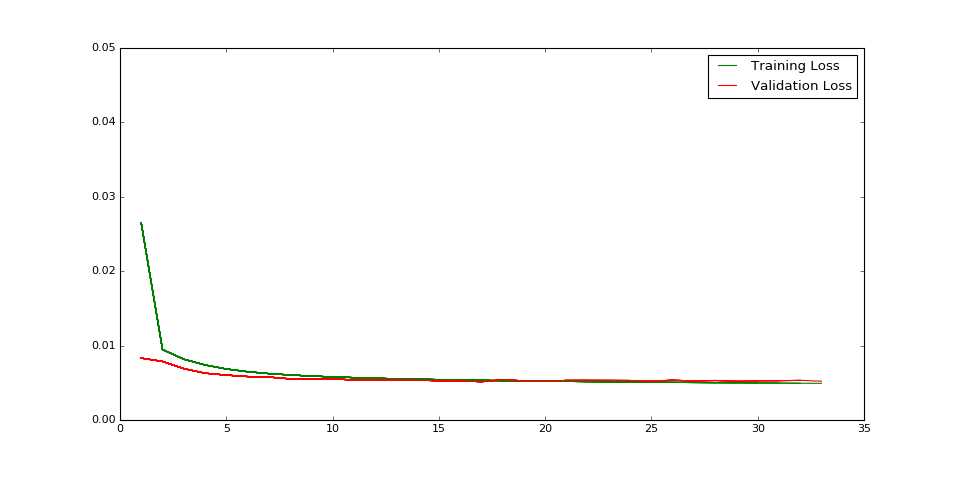

2017-03-28 15:38:08,813 : INFO : Found lower val loss for epoch 1 => 0.00832
2017-03-28 15:38:19,815 : INFO : Found lower val loss for epoch 2 => 0.00787
2017-03-28 15:38:30,560 : INFO : Found lower val loss for epoch 3 => 0.0069
2017-03-28 15:38:40,536 : INFO : Found lower val loss for epoch 4 => 0.00629
2017-03-28 15:38:50,350 : INFO : Found lower val loss for epoch 5 => 0.00603
2017-03-28 15:39:01,077 : INFO : Found lower val loss for epoch 6 => 0.00584
2017-03-28 15:39:11,752 : INFO : Found lower val loss for epoch 7 => 0.00577
2017-03-28 15:39:22,695 : INFO : Found lower val loss for epoch 8 => 0.00553
2017-03-28 15:39:32,592 : INFO : Found lower val loss for epoch 9 => 0.00551
2017-03-28 15:39:43,443 : INFO : Found lower val loss for epoch 10 => 0.00551
2017-03-28 15:39:52,385 : INFO : Found lower val loss for epoch 11 => 0.0054
2017-03-28 15:40:01,819 : INFO : Found lower val loss for epoch 12 => 0.00538
2017-03-28 15:40:19,473 : INFO : Found lower val loss for epoch 14 => 0.005

Epoch 00032: early stopping
CPU times: user 3min 5s, sys: 2min 26s, total: 5min 32s
Wall time: 5min 42s


2017-03-28 15:43:55,204 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 18.994 | Top 3: 0.539 | Top 5: 0.630 | F1 Micro: 0.324 | F1 Macro: 0.031


2017-03-28 15:44:18,879 : INFO : ***************************************************************************************
2017-03-28 15:44:18,882 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           1360200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_99 (Dropout)             (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          402000      dropout_99[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


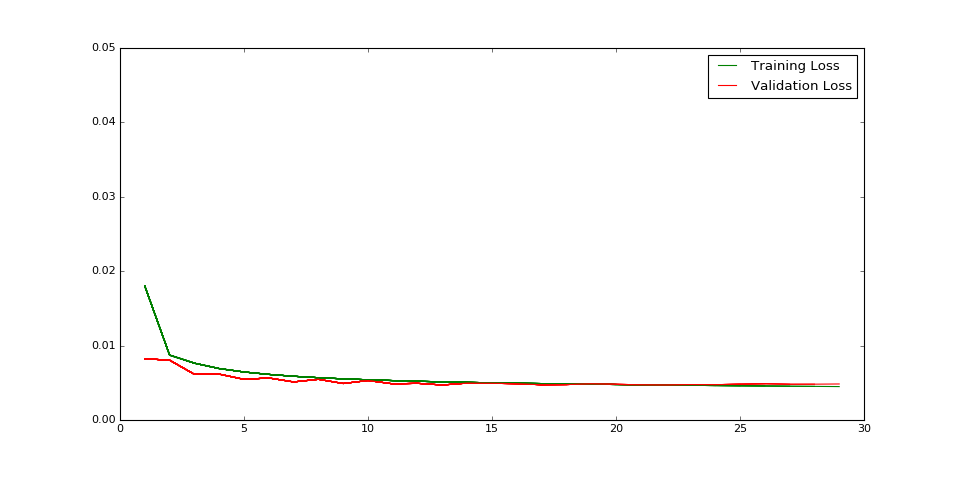

2017-03-28 15:44:33,893 : INFO : Found lower val loss for epoch 1 => 0.00823
2017-03-28 15:44:46,351 : INFO : Found lower val loss for epoch 2 => 0.00804
2017-03-28 15:44:58,603 : INFO : Found lower val loss for epoch 3 => 0.00614
2017-03-28 15:45:22,073 : INFO : Found lower val loss for epoch 5 => 0.00546
2017-03-28 15:45:46,099 : INFO : Found lower val loss for epoch 7 => 0.00512
2017-03-28 15:46:08,096 : INFO : Found lower val loss for epoch 9 => 0.00491
2017-03-28 15:46:33,046 : INFO : Found lower val loss for epoch 11 => 0.00486
2017-03-28 15:46:56,371 : INFO : Found lower val loss for epoch 13 => 0.0047
2017-03-28 15:50:09,698 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00028: early stopping
CPU times: user 2min 55s, sys: 2min 42s, total: 5min 38s
Wall time: 5min 50s


2017-03-28 15:50:27,387 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 14.674 | Top 3: 0.591 | Top 5: 0.685 | F1 Micro: 0.357 | F1 Macro: 0.050


2017-03-28 15:50:50,104 : INFO : ***************************************************************************************
2017-03-28 15:50:50,107 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_100 (Dropout)            (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_100[0][0]                
Total params: 7741940
_____________________________________________________________________

<IPython.core.display.Javascript object>


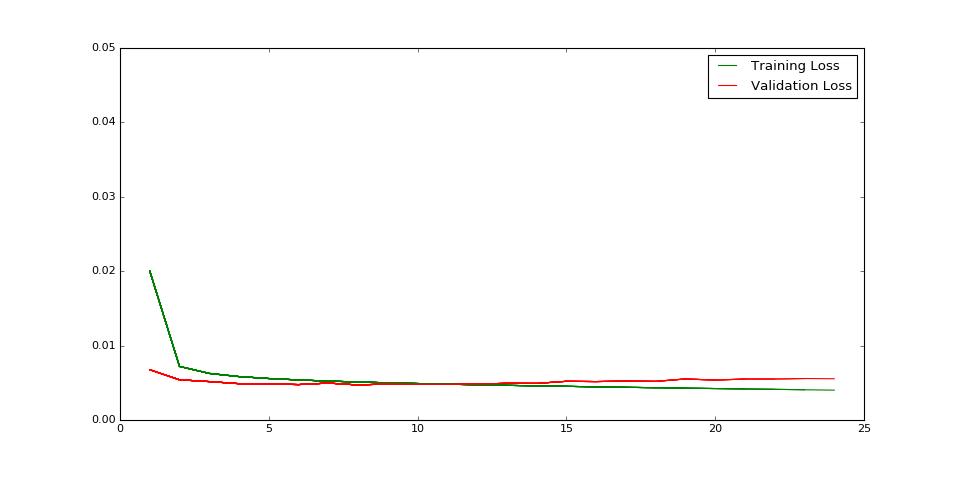

2017-03-28 15:51:04,742 : INFO : Found lower val loss for epoch 1 => 0.00676
2017-03-28 15:51:17,916 : INFO : Found lower val loss for epoch 2 => 0.0054
2017-03-28 15:51:30,406 : INFO : Found lower val loss for epoch 3 => 0.00516
2017-03-28 15:51:42,935 : INFO : Found lower val loss for epoch 4 => 0.00488
2017-03-28 15:51:54,350 : INFO : Found lower val loss for epoch 5 => 0.00484
2017-03-28 15:52:04,046 : INFO : Found lower val loss for epoch 6 => 0.00476
2017-03-28 15:52:23,099 : INFO : Found lower val loss for epoch 8 => 0.00471
2017-03-28 15:54:50,492 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00023: early stopping
CPU times: user 2min 10s, sys: 1min 44s, total: 3min 54s
Wall time: 3min 59s


2017-03-28 15:55:06,843 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 15.435 | Top 3: 0.613 | Top 5: 0.704 | F1 Micro: 0.380 | F1 Macro: 0.065


2017-03-28 15:55:31,417 : INFO : ***************************************************************************************
2017-03-28 15:55:31,418 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           1360200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_101 (Dropout)            (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 500)           100500      dropout_101[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


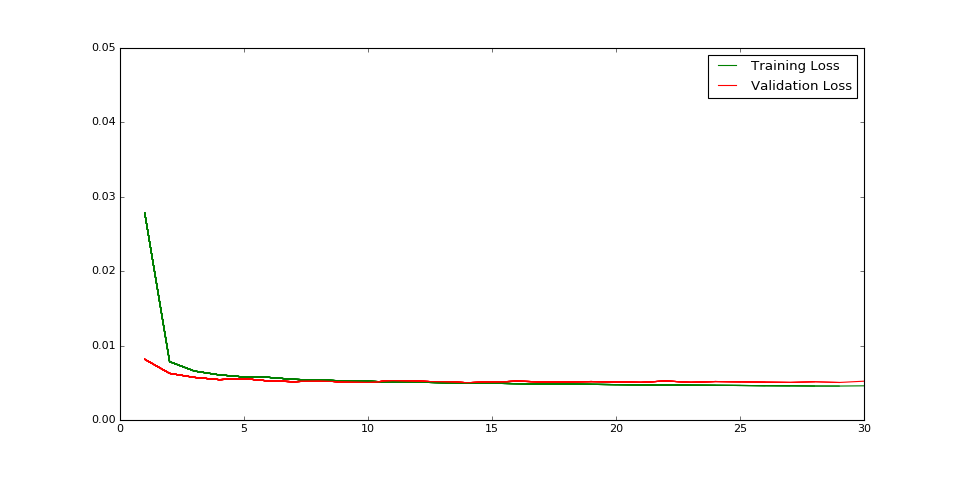

2017-03-28 15:55:44,956 : INFO : Found lower val loss for epoch 1 => 0.00815
2017-03-28 15:55:56,640 : INFO : Found lower val loss for epoch 2 => 0.00627
2017-03-28 15:56:06,426 : INFO : Found lower val loss for epoch 3 => 0.00573
2017-03-28 15:56:17,786 : INFO : Found lower val loss for epoch 4 => 0.00543
2017-03-28 15:56:39,331 : INFO : Found lower val loss for epoch 6 => 0.00525
2017-03-28 15:56:50,548 : INFO : Found lower val loss for epoch 7 => 0.00515
2017-03-28 15:57:08,269 : INFO : Found lower val loss for epoch 9 => 0.00513
2017-03-28 15:57:19,027 : INFO : Found lower val loss for epoch 10 => 0.00506
2017-03-28 15:58:02,050 : INFO : Found lower val loss for epoch 14 => 0.00502
2017-03-28 16:00:53,360 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00029: early stopping
CPU times: user 2min 50s, sys: 2min 19s, total: 5min 9s
Wall time: 5min 21s


2017-03-28 16:01:09,592 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 17.263 | Top 3: 0.560 | Top 5: 0.656 | F1 Micro: 0.329 | F1 Macro: 0.046


2017-03-28 16:01:33,260 : INFO : ***************************************************************************************
2017-03-28 16:01:33,262 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_102 (Dropout)            (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_102[0][0]                
Total params: 7741940
_____________________________________________________________________

<IPython.core.display.Javascript object>


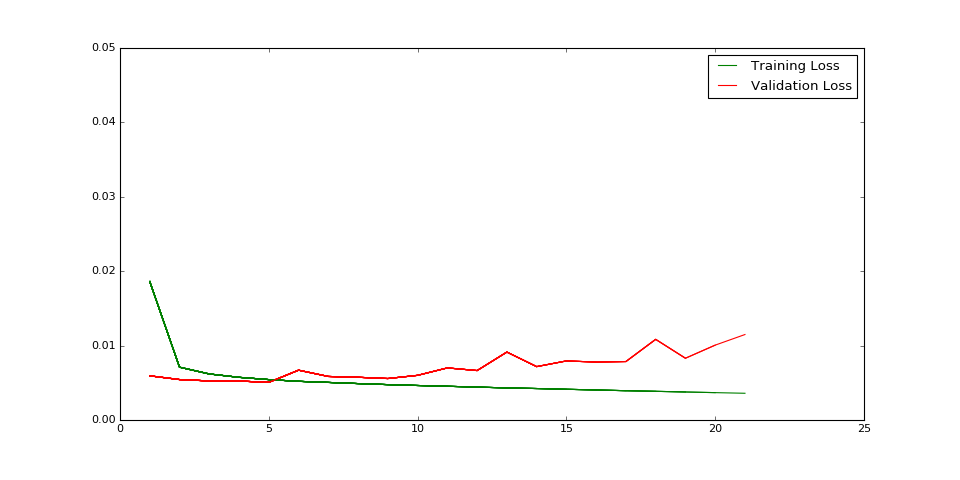

2017-03-28 16:01:48,171 : INFO : Found lower val loss for epoch 1 => 0.00594
2017-03-28 16:02:01,136 : INFO : Found lower val loss for epoch 2 => 0.00544
2017-03-28 16:02:14,046 : INFO : Found lower val loss for epoch 3 => 0.00525
2017-03-28 16:02:27,027 : INFO : Found lower val loss for epoch 4 => 0.00524
2017-03-28 16:02:39,591 : INFO : Found lower val loss for epoch 5 => 0.00506
2017-03-28 16:05:50,919 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00020: early stopping
CPU times: user 2min 8s, sys: 2min, total: 4min 9s
Wall time: 4min 17s


2017-03-28 16:06:07,102 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 15.656 | Top 3: 0.616 | Top 5: 0.705 | F1 Micro: 0.436 | F1 Macro: 0.070


2017-03-28 16:06:30,069 : INFO : ***************************************************************************************
2017-03-28 16:06:30,069 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           1360200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_103 (Dropout)            (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          402000      dropout_103[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


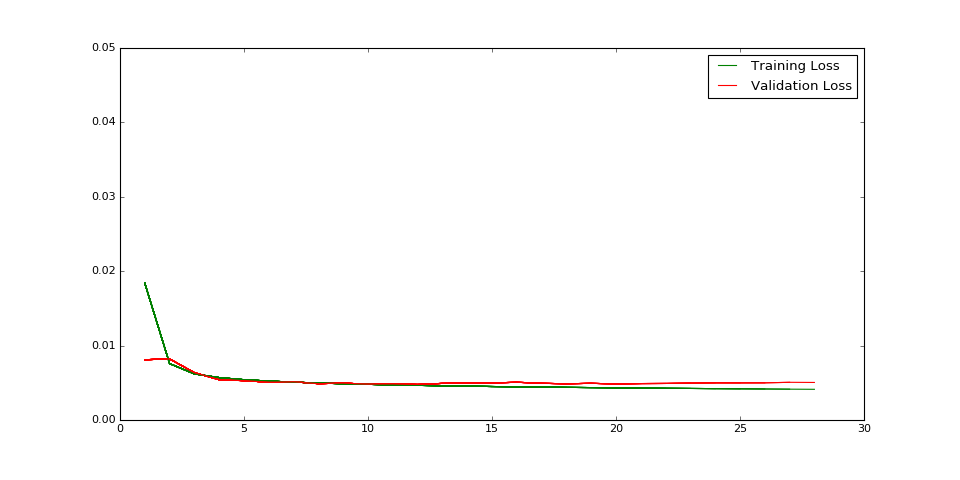

2017-03-28 16:06:44,918 : INFO : Found lower val loss for epoch 1 => 0.0081
2017-03-28 16:07:11,198 : INFO : Found lower val loss for epoch 3 => 0.00636
2017-03-28 16:07:25,026 : INFO : Found lower val loss for epoch 4 => 0.00541
2017-03-28 16:07:38,024 : INFO : Found lower val loss for epoch 5 => 0.00529
2017-03-28 16:07:49,818 : INFO : Found lower val loss for epoch 6 => 0.00508
2017-03-28 16:08:14,330 : INFO : Found lower val loss for epoch 8 => 0.00488
2017-03-28 16:08:38,462 : INFO : Found lower val loss for epoch 10 => 0.00481
2017-03-28 16:09:02,985 : INFO : Found lower val loss for epoch 12 => 0.00478
2017-03-28 16:12:17,413 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00027: early stopping
CPU times: user 2min 51s, sys: 2min 40s, total: 5min 32s
Wall time: 5min 47s


2017-03-28 16:12:32,164 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.647 | Top 3: 0.612 | Top 5: 0.706 | F1 Micro: 0.417 | F1 Macro: 0.084


2017-03-28 16:12:55,329 : INFO : ***************************************************************************************
2017-03-28 16:12:55,331 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_104 (Dropout)            (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 1000)          101000      dropout_104[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


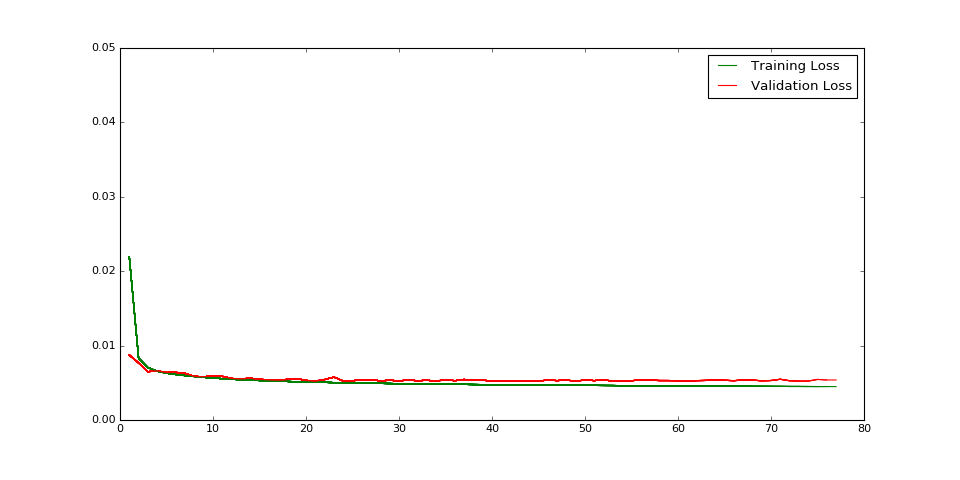

2017-03-28 16:13:08,816 : INFO : Found lower val loss for epoch 1 => 0.00874
2017-03-28 16:13:20,428 : INFO : Found lower val loss for epoch 2 => 0.00767
2017-03-28 16:13:31,647 : INFO : Found lower val loss for epoch 3 => 0.0065
2017-03-28 16:13:53,710 : INFO : Found lower val loss for epoch 5 => 0.00638
2017-03-28 16:14:16,215 : INFO : Found lower val loss for epoch 7 => 0.00626
2017-03-28 16:14:26,461 : INFO : Found lower val loss for epoch 8 => 0.00586
2017-03-28 16:14:36,705 : INFO : Found lower val loss for epoch 9 => 0.00581
2017-03-28 16:15:08,183 : INFO : Found lower val loss for epoch 12 => 0.00558
2017-03-28 16:15:18,645 : INFO : Found lower val loss for epoch 13 => 0.00552
2017-03-28 16:15:40,999 : INFO : Found lower val loss for epoch 15 => 0.00546
2017-03-28 16:15:52,208 : INFO : Found lower val loss for epoch 16 => 0.00541
2017-03-28 16:16:01,861 : INFO : Found lower val loss for epoch 17 => 0.00537
2017-03-28 16:16:34,052 : INFO : Found lower val loss for epoch 20 => 0.

Epoch 00076: early stopping
CPU times: user 7min 18s, sys: 6min 2s, total: 13min 21s
Wall time: 13min 45s


2017-03-28 16:26:54,866 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 16.179 | Top 3: 0.565 | Top 5: 0.662 | F1 Micro: 0.354 | F1 Macro: 0.063


2017-03-28 16:27:18,746 : INFO : ***************************************************************************************
2017-03-28 16:27:18,748 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_105 (Dropout)            (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          1002000     dropout_105[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


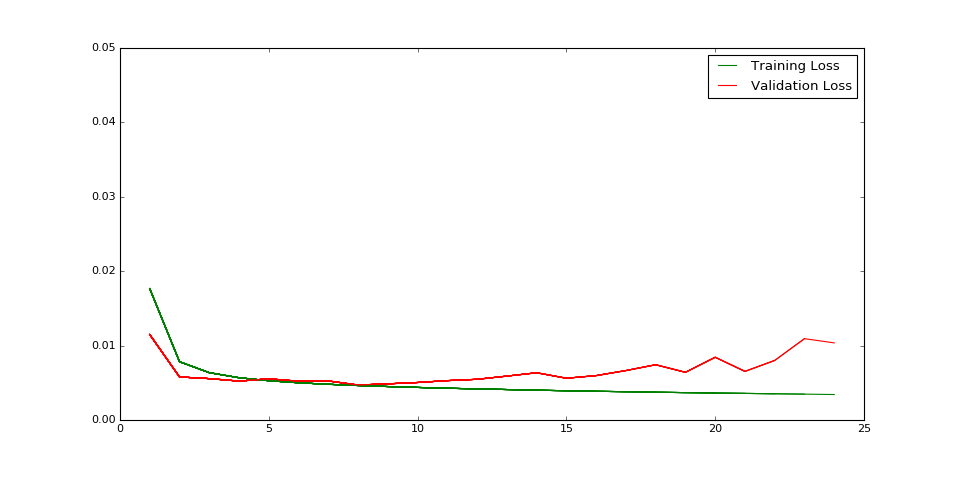

2017-03-28 16:27:34,521 : INFO : Found lower val loss for epoch 1 => 0.01148
2017-03-28 16:27:48,271 : INFO : Found lower val loss for epoch 2 => 0.00578
2017-03-28 16:28:00,973 : INFO : Found lower val loss for epoch 3 => 0.00556
2017-03-28 16:28:14,157 : INFO : Found lower val loss for epoch 4 => 0.00523
2017-03-28 16:28:38,359 : INFO : Found lower val loss for epoch 6 => 0.00521
2017-03-28 16:29:02,915 : INFO : Found lower val loss for epoch 8 => 0.0047
2017-03-28 16:32:30,375 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00023: early stopping
CPU times: user 2min 31s, sys: 2min 26s, total: 4min 58s
Wall time: 5min 11s


2017-03-28 16:32:48,261 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.493 | Top 3: 0.614 | Top 5: 0.708 | F1 Micro: 0.402 | F1 Macro: 0.093


2017-03-28 16:33:12,466 : INFO : ***************************************************************************************
2017-03-28 16:33:12,469 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_106 (Dropout)            (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 2000)          2002000     dropout_106[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


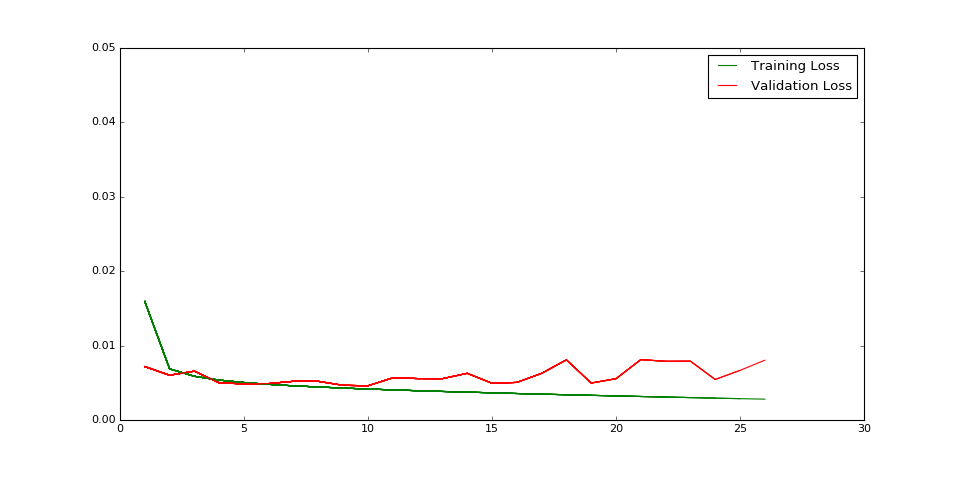

2017-03-28 16:33:30,128 : INFO : Found lower val loss for epoch 1 => 0.00717
2017-03-28 16:33:45,139 : INFO : Found lower val loss for epoch 2 => 0.00602
2017-03-28 16:34:14,117 : INFO : Found lower val loss for epoch 4 => 0.00499
2017-03-28 16:34:28,042 : INFO : Found lower val loss for epoch 5 => 0.00486
2017-03-28 16:35:25,784 : INFO : Found lower val loss for epoch 9 => 0.00466
2017-03-28 16:35:39,678 : INFO : Found lower val loss for epoch 10 => 0.0046
2017-03-28 16:39:13,265 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00025: early stopping
CPU times: user 2min 53s, sys: 2min 54s, total: 5min 47s
Wall time: 6min


2017-03-28 16:39:30,885 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 12.579 | Top 3: 0.624 | Top 5: 0.716 | F1 Micro: 0.411 | F1 Macro: 0.089


2017-03-28 16:39:54,739 : INFO : ***************************************************************************************
2017-03-28 16:39:54,741 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           1360200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_107 (Dropout)            (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          201000      dropout_107[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


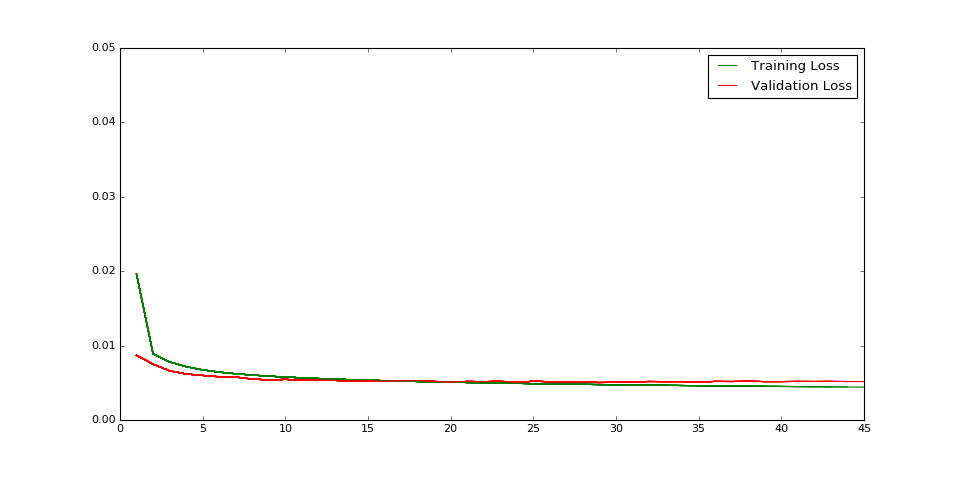

2017-03-28 16:40:08,922 : INFO : Found lower val loss for epoch 1 => 0.0087
2017-03-28 16:40:20,382 : INFO : Found lower val loss for epoch 2 => 0.0075
2017-03-28 16:40:31,552 : INFO : Found lower val loss for epoch 3 => 0.00661
2017-03-28 16:40:42,718 : INFO : Found lower val loss for epoch 4 => 0.00618
2017-03-28 16:40:52,744 : INFO : Found lower val loss for epoch 5 => 0.00599
2017-03-28 16:41:03,885 : INFO : Found lower val loss for epoch 6 => 0.00581
2017-03-28 16:41:14,092 : INFO : Found lower val loss for epoch 7 => 0.00577
2017-03-28 16:41:24,076 : INFO : Found lower val loss for epoch 8 => 0.0055
2017-03-28 16:41:34,103 : INFO : Found lower val loss for epoch 9 => 0.00538
2017-03-28 16:41:54,546 : INFO : Found lower val loss for epoch 11 => 0.00536
2017-03-28 16:42:04,249 : INFO : Found lower val loss for epoch 12 => 0.00533
2017-03-28 16:42:13,679 : INFO : Found lower val loss for epoch 13 => 0.00532
2017-03-28 16:42:21,607 : INFO : Found lower val loss for epoch 14 => 0.0052

Epoch 00044: early stopping
CPU times: user 4min 13s, sys: 3min 30s, total: 7min 43s
Wall time: 7min 59s


2017-03-28 16:48:09,729 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 17.006 | Top 3: 0.548 | Top 5: 0.644 | F1 Micro: 0.309 | F1 Macro: 0.040


2017-03-28 16:48:33,321 : INFO : ***************************************************************************************
2017-03-28 16:48:33,324 : INFO : nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_108 (Dropout)            (None, 100)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 1000)          101000      dropout_108[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


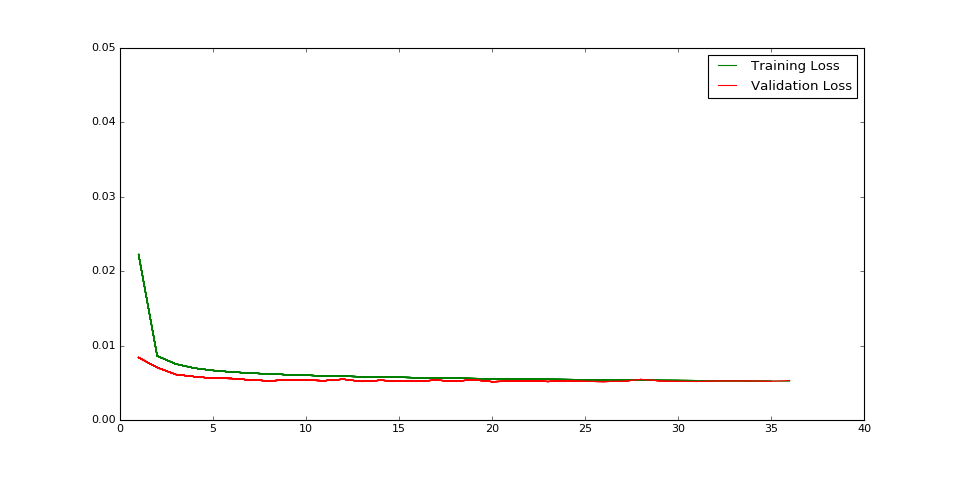

2017-03-28 16:48:46,747 : INFO : Found lower val loss for epoch 1 => 0.00839
2017-03-28 16:48:57,663 : INFO : Found lower val loss for epoch 2 => 0.00706
2017-03-28 16:49:07,323 : INFO : Found lower val loss for epoch 3 => 0.00612
2017-03-28 16:49:17,920 : INFO : Found lower val loss for epoch 4 => 0.00583
2017-03-28 16:49:28,253 : INFO : Found lower val loss for epoch 5 => 0.0056
2017-03-28 16:49:39,432 : INFO : Found lower val loss for epoch 6 => 0.00558
2017-03-28 16:49:49,876 : INFO : Found lower val loss for epoch 7 => 0.00538
2017-03-28 16:50:00,751 : INFO : Found lower val loss for epoch 8 => 0.00527
2017-03-28 16:50:48,999 : INFO : Found lower val loss for epoch 13 => 0.00518
2017-03-28 16:52:02,664 : INFO : Found lower val loss for epoch 20 => 0.00516
2017-03-28 16:54:50,141 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00035: early stopping
CPU times: user 3min 27s, sys: 2min 41s, total: 6min 8s
Wall time: 6min 16s


2017-03-28 16:55:07,062 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 17.992 | Top 3: 0.547 | Top 5: 0.640 | F1 Micro: 0.325 | F1 Macro: 0.030


2017-03-28 16:55:30,654 : INFO : ***************************************************************************************
2017-03-28 16:55:30,656 : INFO : nn_1st-size_100_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_109 (Dropout)            (None, 100)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          202000      dropout_109[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


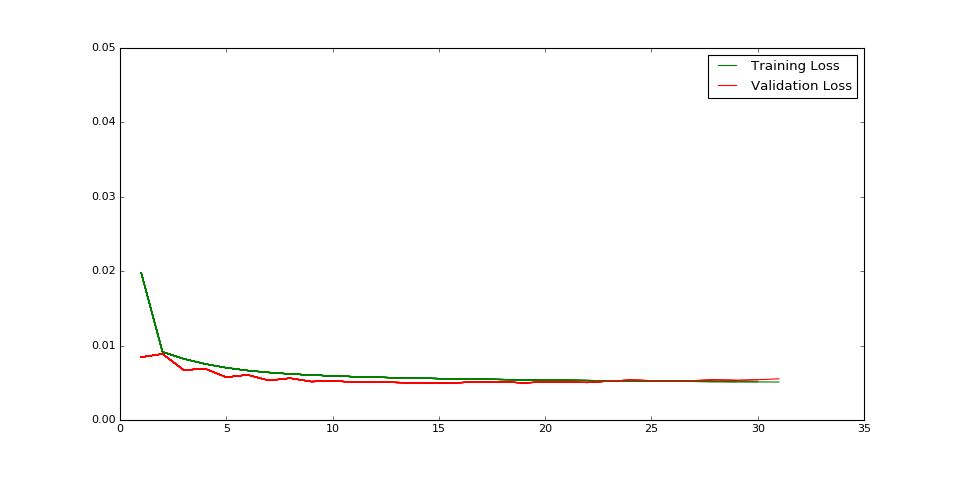

2017-03-28 16:55:43,802 : INFO : Found lower val loss for epoch 1 => 0.00845
2017-03-28 16:56:03,558 : INFO : Found lower val loss for epoch 3 => 0.00671
2017-03-28 16:56:23,724 : INFO : Found lower val loss for epoch 5 => 0.00575
2017-03-28 16:56:44,747 : INFO : Found lower val loss for epoch 7 => 0.00531
2017-03-28 16:57:06,134 : INFO : Found lower val loss for epoch 9 => 0.00517
2017-03-28 16:57:27,506 : INFO : Found lower val loss for epoch 11 => 0.00511
2017-03-28 16:57:36,968 : INFO : Found lower val loss for epoch 12 => 0.00511
2017-03-28 16:57:46,439 : INFO : Found lower val loss for epoch 13 => 0.00504
2017-03-28 16:57:57,748 : INFO : Found lower val loss for epoch 14 => 0.00499
2017-03-28 16:58:09,297 : INFO : Found lower val loss for epoch 15 => 0.00497
2017-03-28 17:01:07,001 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00030: early stopping
CPU times: user 2min 57s, sys: 2min 29s, total: 5min 27s
Wall time: 5min 35s


2017-03-28 17:01:23,602 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 17.109 | Top 3: 0.554 | Top 5: 0.651 | F1 Micro: 0.283 | F1 Macro: 0.028


2017-03-28 17:01:47,162 : INFO : ***************************************************************************************
2017-03-28 17:01:47,164 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_110 (Dropout)            (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           250500      dropout_110[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


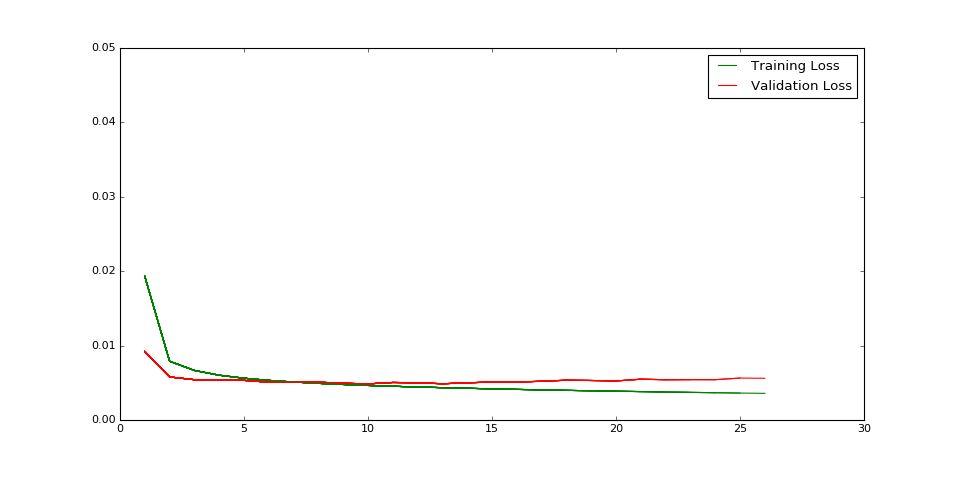

2017-03-28 17:02:02,224 : INFO : Found lower val loss for epoch 1 => 0.00921
2017-03-28 17:02:14,216 : INFO : Found lower val loss for epoch 2 => 0.00579
2017-03-28 17:02:26,029 : INFO : Found lower val loss for epoch 3 => 0.00542
2017-03-28 17:02:37,719 : INFO : Found lower val loss for epoch 4 => 0.00535
2017-03-28 17:02:48,861 : INFO : Found lower val loss for epoch 5 => 0.00533
2017-03-28 17:02:59,823 : INFO : Found lower val loss for epoch 6 => 0.00508
2017-03-28 17:03:36,709 : INFO : Found lower val loss for epoch 9 => 0.00494
2017-03-28 17:03:48,991 : INFO : Found lower val loss for epoch 10 => 0.00485
2017-03-28 17:06:47,978 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00025: early stopping
CPU times: user 2min 35s, sys: 2min 14s, total: 4min 50s
Wall time: 5min


2017-03-28 17:07:04,899 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.178 | Top 3: 0.623 | Top 5: 0.715 | F1 Micro: 0.446 | F1 Macro: 0.102


2017-03-28 17:07:27,654 : INFO : ***************************************************************************************
2017-03-28 17:07:27,657 : INFO : nn_1st-size_500_1st-act_sigmoid_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_111 (Dropout)            (None, 500)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 2000)          1002000     dropout_111[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


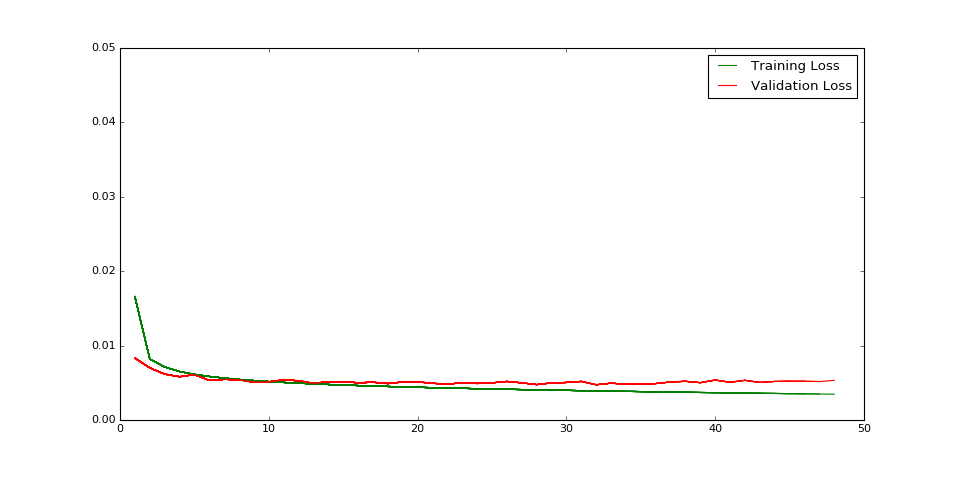

2017-03-28 17:07:42,858 : INFO : Found lower val loss for epoch 1 => 0.00832
2017-03-28 17:07:55,666 : INFO : Found lower val loss for epoch 2 => 0.00701
2017-03-28 17:08:08,684 : INFO : Found lower val loss for epoch 3 => 0.00617
2017-03-28 17:08:21,272 : INFO : Found lower val loss for epoch 4 => 0.00582
2017-03-28 17:08:45,861 : INFO : Found lower val loss for epoch 6 => 0.00532
2017-03-28 17:09:21,273 : INFO : Found lower val loss for epoch 9 => 0.00507
2017-03-28 17:10:07,655 : INFO : Found lower val loss for epoch 13 => 0.00493
2017-03-28 17:11:08,289 : INFO : Found lower val loss for epoch 18 => 0.0049
2017-03-28 17:11:59,344 : INFO : Found lower val loss for epoch 22 => 0.0048
2017-03-28 17:13:14,707 : INFO : Found lower val loss for epoch 28 => 0.00476
2017-03-28 17:14:03,554 : INFO : Found lower val loss for epoch 32 => 0.00474
2017-03-28 17:17:20,636 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00047: early stopping
CPU times: user 4min 54s, sys: 4min 35s, total: 9min 30s
Wall time: 9min 52s


2017-03-28 17:17:37,340 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 14.266 | Top 3: 0.589 | Top 5: 0.682 | F1 Micro: 0.331 | F1 Macro: 0.066


2017-03-28 17:18:00,585 : INFO : ***************************************************************************************
2017-03-28 17:18:00,587 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_112 (Dropout)            (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          1001000     dropout_112[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


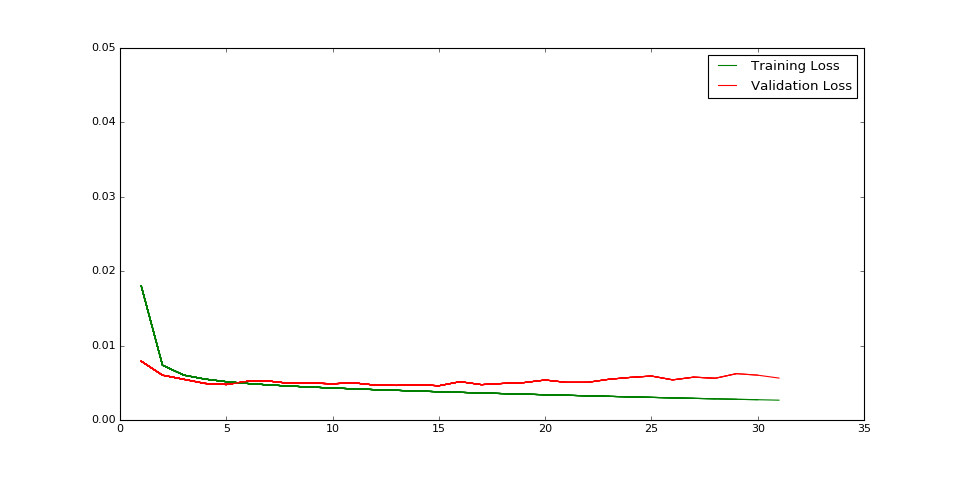

2017-03-28 17:18:16,826 : INFO : Found lower val loss for epoch 1 => 0.0079
2017-03-28 17:18:30,303 : INFO : Found lower val loss for epoch 2 => 0.00602
2017-03-28 17:18:42,805 : INFO : Found lower val loss for epoch 3 => 0.00547
2017-03-28 17:18:55,938 : INFO : Found lower val loss for epoch 4 => 0.00491
2017-03-28 17:19:08,510 : INFO : Found lower val loss for epoch 5 => 0.00477
2017-03-28 17:20:37,435 : INFO : Found lower val loss for epoch 12 => 0.00469
2017-03-28 17:20:50,342 : INFO : Found lower val loss for epoch 13 => 0.00464
2017-03-28 17:21:15,996 : INFO : Found lower val loss for epoch 15 => 0.0046
2017-03-28 17:24:38,847 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00030: early stopping
CPU times: user 3min 16s, sys: 3min 6s, total: 6min 22s
Wall time: 6min 37s


2017-03-28 17:24:57,040 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 12.908 | Top 3: 0.611 | Top 5: 0.707 | F1 Micro: 0.414 | F1 Macro: 0.097


2017-03-28 17:25:19,929 : INFO : ***************************************************************************************
2017-03-28 17:25:19,931 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_113 (Dropout)            (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_113[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


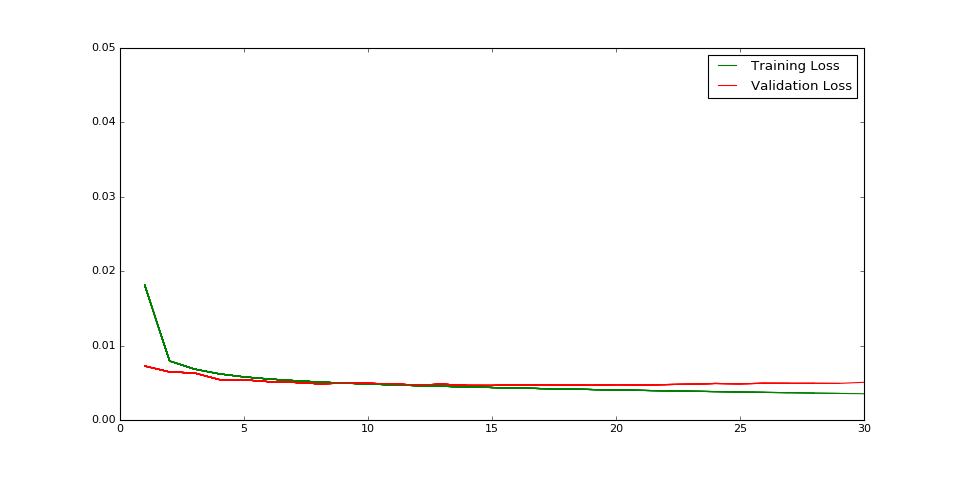

2017-03-28 17:25:34,318 : INFO : Found lower val loss for epoch 1 => 0.00725
2017-03-28 17:25:47,353 : INFO : Found lower val loss for epoch 2 => 0.00646
2017-03-28 17:26:00,943 : INFO : Found lower val loss for epoch 3 => 0.00632
2017-03-28 17:26:14,446 : INFO : Found lower val loss for epoch 4 => 0.00544
2017-03-28 17:26:27,976 : INFO : Found lower val loss for epoch 5 => 0.0054
2017-03-28 17:26:40,881 : INFO : Found lower val loss for epoch 6 => 0.00515
2017-03-28 17:26:53,958 : INFO : Found lower val loss for epoch 7 => 0.00505
2017-03-28 17:27:07,011 : INFO : Found lower val loss for epoch 8 => 0.00487
2017-03-28 17:27:45,410 : INFO : Found lower val loss for epoch 11 => 0.00484
2017-03-28 17:27:58,991 : INFO : Found lower val loss for epoch 12 => 0.0047
2017-03-28 17:28:23,839 : INFO : Found lower val loss for epoch 14 => 0.00464
2017-03-28 17:28:33,921 : INFO : Found lower val loss for epoch 15 => 0.00464
2017-03-28 17:31:37,652 : INFO : Evaluating on Validation Data using saved

Epoch 00029: early stopping
CPU times: user 3min 8s, sys: 2min 54s, total: 6min 2s
Wall time: 6min 17s


2017-03-28 17:31:52,478 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.282 | Top 3: 0.622 | Top 5: 0.714 | F1 Micro: 0.430 | F1 Macro: 0.094


2017-03-28 17:32:18,110 : INFO : ***************************************************************************************
2017-03-28 17:32:18,112 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_114 (Dropout)            (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_114[0][0]                
Total params: 7741940
_____________________________________________________________________

<IPython.core.display.Javascript object>


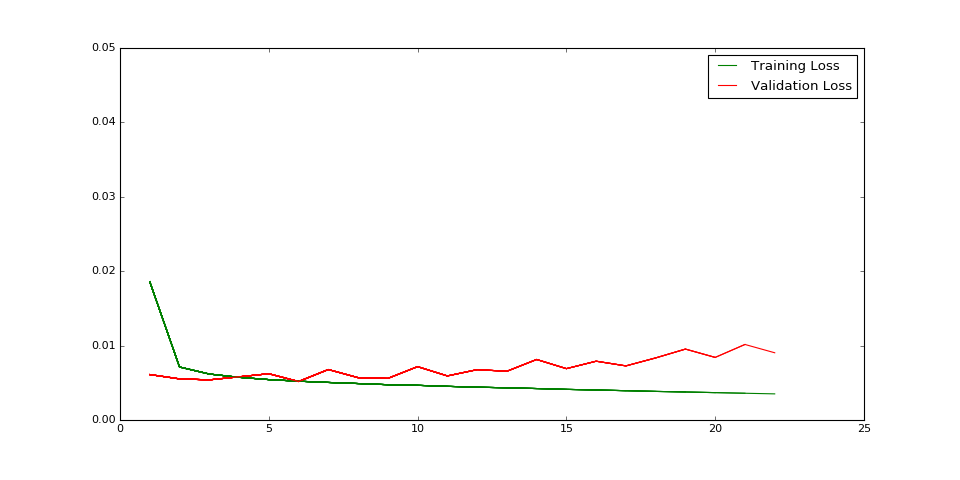

2017-03-28 17:32:32,954 : INFO : Found lower val loss for epoch 1 => 0.00611
2017-03-28 17:32:45,454 : INFO : Found lower val loss for epoch 2 => 0.00553
2017-03-28 17:32:57,017 : INFO : Found lower val loss for epoch 3 => 0.0054
2017-03-28 17:33:32,190 : INFO : Found lower val loss for epoch 6 => 0.00518
2017-03-28 17:36:31,628 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00021: early stopping
CPU times: user 2min 10s, sys: 1min 55s, total: 4min 5s
Wall time: 4min 13s


2017-03-28 17:36:48,550 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 14.702 | Top 3: 0.623 | Top 5: 0.712 | F1 Micro: 0.428 | F1 Macro: 0.073


2017-03-28 17:37:12,785 : INFO : ***************************************************************************************
2017-03-28 17:37:12,788 : INFO : nn_1st-size_1000_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_115 (Dropout)            (None, 1000)          0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           500500      dropout_115[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


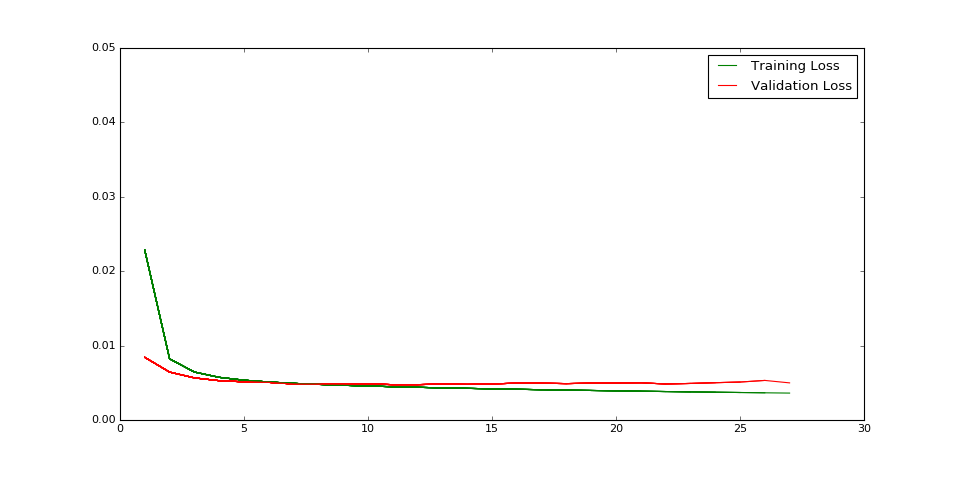

2017-03-28 17:37:27,945 : INFO : Found lower val loss for epoch 1 => 0.00842
2017-03-28 17:37:38,562 : INFO : Found lower val loss for epoch 2 => 0.00644
2017-03-28 17:37:50,024 : INFO : Found lower val loss for epoch 3 => 0.00566
2017-03-28 17:38:03,495 : INFO : Found lower val loss for epoch 4 => 0.00528
2017-03-28 17:38:16,573 : INFO : Found lower val loss for epoch 5 => 0.00513
2017-03-28 17:38:29,902 : INFO : Found lower val loss for epoch 6 => 0.00506
2017-03-28 17:38:42,599 : INFO : Found lower val loss for epoch 7 => 0.00484
2017-03-28 17:38:54,137 : INFO : Found lower val loss for epoch 8 => 0.00479
2017-03-28 17:39:31,512 : INFO : Found lower val loss for epoch 11 => 0.00475
2017-03-28 17:42:50,556 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00026: early stopping
CPU times: user 2min 48s, sys: 2min 37s, total: 5min 25s
Wall time: 5min 37s


2017-03-28 17:43:08,186 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 14.590 | Top 3: 0.598 | Top 5: 0.691 | F1 Micro: 0.356 | F1 Macro: 0.048


2017-03-28 17:43:34,591 : INFO : ***************************************************************************************
2017-03-28 17:43:34,593 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_116 (Dropout)            (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 2000)          1002000     dropout_116[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


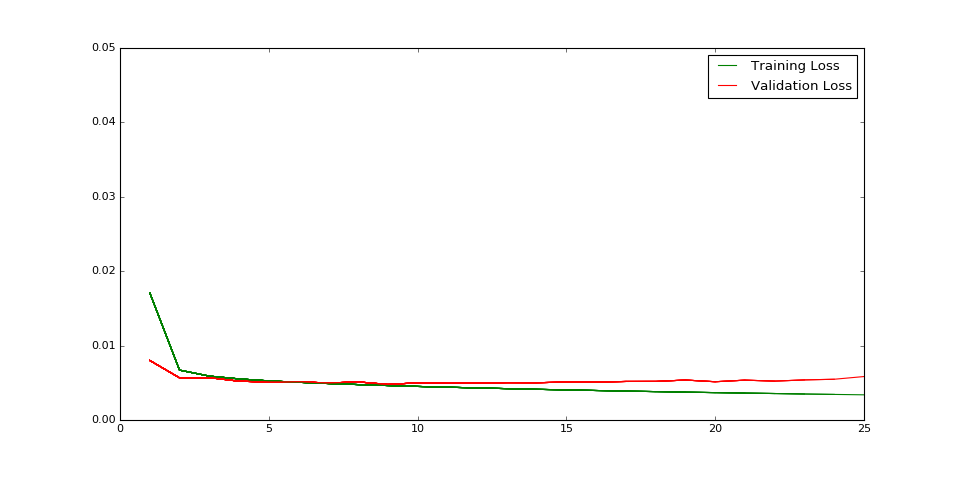

2017-03-28 17:43:49,595 : INFO : Found lower val loss for epoch 1 => 0.008
2017-03-28 17:44:02,191 : INFO : Found lower val loss for epoch 2 => 0.00567
2017-03-28 17:44:27,678 : INFO : Found lower val loss for epoch 4 => 0.00522
2017-03-28 17:44:40,620 : INFO : Found lower val loss for epoch 5 => 0.00511
2017-03-28 17:45:06,562 : INFO : Found lower val loss for epoch 7 => 0.00497
2017-03-28 17:45:32,270 : INFO : Found lower val loss for epoch 9 => 0.00478
2017-03-28 17:48:48,920 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00024: early stopping
CPU times: user 2min 34s, sys: 2min 27s, total: 5min 2s
Wall time: 5min 13s


2017-03-28 17:49:05,591 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.862 | Top 3: 0.614 | Top 5: 0.708 | F1 Micro: 0.433 | F1 Macro: 0.084


2017-03-28 17:49:28,978 : INFO : ***************************************************************************************
2017-03-28 17:49:28,981 : INFO : nn_1st-size_500_1st-act_tanh_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_117 (Dropout)            (None, 500)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           250500      dropout_117[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


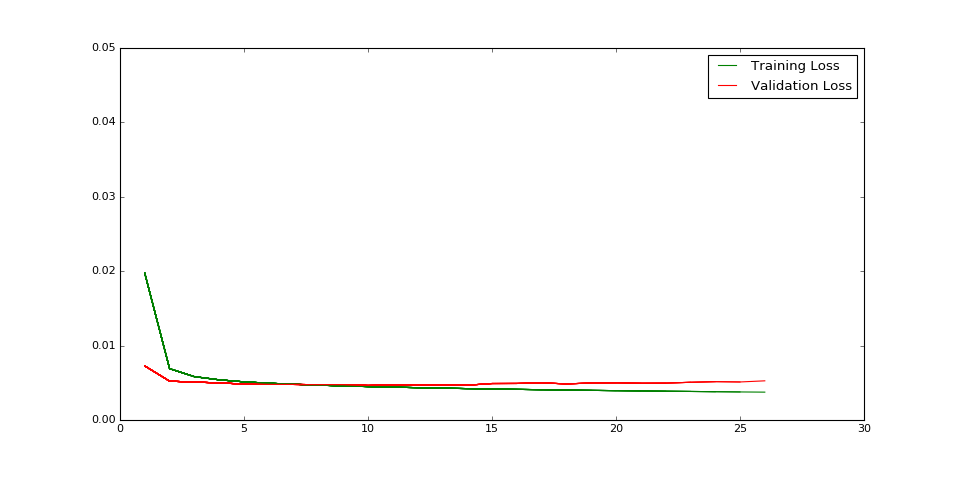

2017-03-28 17:49:43,680 : INFO : Found lower val loss for epoch 1 => 0.00726
2017-03-28 17:49:56,886 : INFO : Found lower val loss for epoch 2 => 0.00522
2017-03-28 17:50:09,879 : INFO : Found lower val loss for epoch 3 => 0.00509
2017-03-28 17:50:21,846 : INFO : Found lower val loss for epoch 4 => 0.00499
2017-03-28 17:50:34,979 : INFO : Found lower val loss for epoch 5 => 0.00483
2017-03-28 17:50:47,390 : INFO : Found lower val loss for epoch 6 => 0.00479
2017-03-28 17:50:59,513 : INFO : Found lower val loss for epoch 7 => 0.00478
2017-03-28 17:51:12,552 : INFO : Found lower val loss for epoch 8 => 0.00475
2017-03-28 17:51:38,045 : INFO : Found lower val loss for epoch 10 => 0.00464
2017-03-28 17:54:58,674 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00025: early stopping
CPU times: user 2min 26s, sys: 2min 48s, total: 5min 15s
Wall time: 5min 29s


2017-03-28 17:55:15,597 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.587 | Top 3: 0.619 | Top 5: 0.710 | F1 Micro: 0.407 | F1 Macro: 0.081


2017-03-28 17:55:40,244 : INFO : ***************************************************************************************
2017-03-28 17:55:40,245 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_118 (Dropout)            (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_118[0][0]                
Total params: 7741940
_____________________________________________________________________

<IPython.core.display.Javascript object>


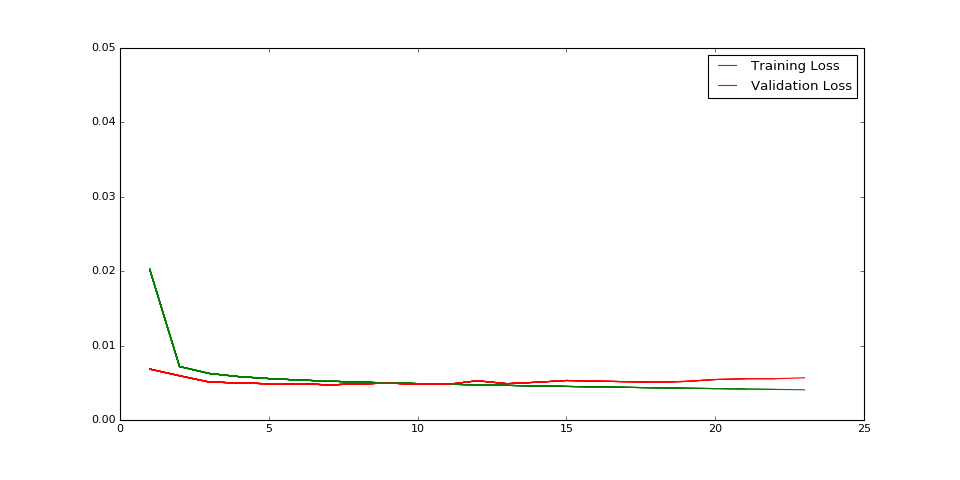

2017-03-28 17:55:55,100 : INFO : Found lower val loss for epoch 1 => 0.00684
2017-03-28 17:56:07,198 : INFO : Found lower val loss for epoch 2 => 0.00595
2017-03-28 17:56:19,259 : INFO : Found lower val loss for epoch 3 => 0.0051
2017-03-28 17:56:30,848 : INFO : Found lower val loss for epoch 4 => 0.00498
2017-03-28 17:56:42,788 : INFO : Found lower val loss for epoch 5 => 0.00487
2017-03-28 17:57:06,332 : INFO : Found lower val loss for epoch 7 => 0.00472
2017-03-28 18:00:12,423 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00022: early stopping
CPU times: user 2min 17s, sys: 2min 5s, total: 4min 23s
Wall time: 4min 31s


2017-03-28 18:00:29,159 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 16.132 | Top 3: 0.610 | Top 5: 0.699 | F1 Micro: 0.386 | F1 Macro: 0.064


2017-03-28 18:00:54,312 : INFO : ***************************************************************************************
2017-03-28 18:00:54,313 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           1360200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_119 (Dropout)            (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 2000)          402000      dropout_119[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


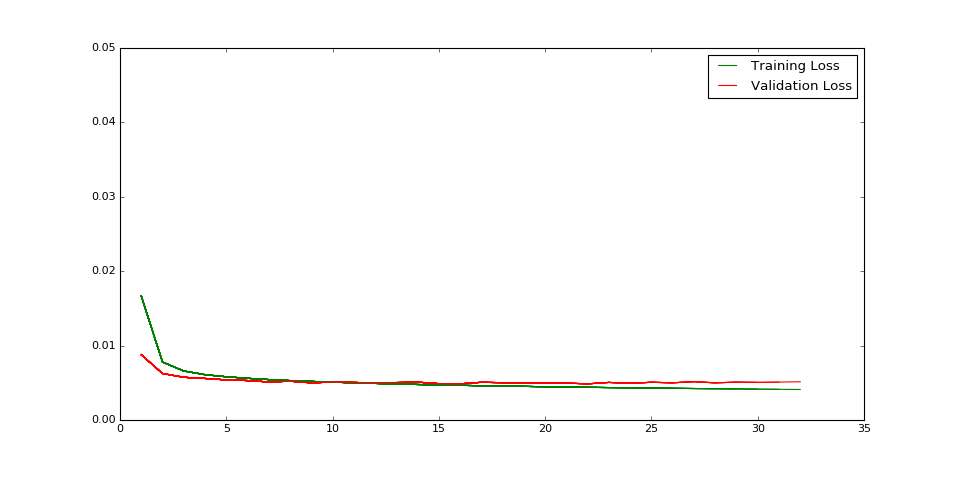

2017-03-28 18:01:08,798 : INFO : Found lower val loss for epoch 1 => 0.00877
2017-03-28 18:01:19,108 : INFO : Found lower val loss for epoch 2 => 0.00625
2017-03-28 18:01:30,233 : INFO : Found lower val loss for epoch 3 => 0.00574
2017-03-28 18:01:42,303 : INFO : Found lower val loss for epoch 4 => 0.00558
2017-03-28 18:01:54,042 : INFO : Found lower val loss for epoch 5 => 0.00539
2017-03-28 18:02:05,103 : INFO : Found lower val loss for epoch 6 => 0.0053
2017-03-28 18:02:17,269 : INFO : Found lower val loss for epoch 7 => 0.00511
2017-03-28 18:02:38,144 : INFO : Found lower val loss for epoch 9 => 0.00499
2017-03-28 18:03:11,531 : INFO : Found lower val loss for epoch 12 => 0.00499
2017-03-28 18:03:44,301 : INFO : Found lower val loss for epoch 15 => 0.00489
2017-03-28 18:03:56,219 : INFO : Found lower val loss for epoch 16 => 0.00487
2017-03-28 18:05:04,866 : INFO : Found lower val loss for epoch 22 => 0.00486
2017-03-28 18:07:02,749 : INFO : Evaluating on Validation Data using save

Epoch 00031: early stopping
CPU times: user 3min 10s, sys: 2min 43s, total: 5min 53s
Wall time: 6min 8s


2017-03-28 18:07:18,134 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 15.099 | Top 3: 0.588 | Top 5: 0.681 | F1 Micro: 0.389 | F1 Macro: 0.077


2017-03-28 18:07:44,296 : INFO : ***************************************************************************************
2017-03-28 18:07:44,297 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_120 (Dropout)            (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           250500      dropout_120[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


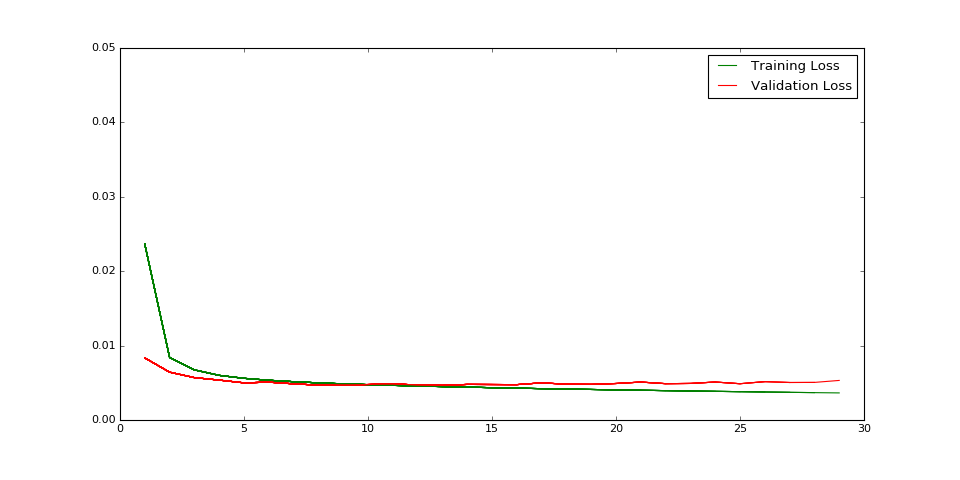

2017-03-28 18:07:58,682 : INFO : Found lower val loss for epoch 1 => 0.00834
2017-03-28 18:08:10,801 : INFO : Found lower val loss for epoch 2 => 0.00643
2017-03-28 18:08:22,605 : INFO : Found lower val loss for epoch 3 => 0.0057
2017-03-28 18:08:34,563 : INFO : Found lower val loss for epoch 4 => 0.00536
2017-03-28 18:08:46,810 : INFO : Found lower val loss for epoch 5 => 0.00499
2017-03-28 18:09:08,671 : INFO : Found lower val loss for epoch 7 => 0.00486
2017-03-28 18:09:20,224 : INFO : Found lower val loss for epoch 8 => 0.00469
2017-03-28 18:10:15,694 : INFO : Found lower val loss for epoch 13 => 0.00465
2017-03-28 18:13:21,705 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00028: early stopping
CPU times: user 2min 54s, sys: 2min 31s, total: 5min 25s
Wall time: 5min 36s


2017-03-28 18:13:39,910 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.695 | Top 3: 0.606 | Top 5: 0.701 | F1 Micro: 0.418 | F1 Macro: 0.070


2017-03-28 18:14:06,014 : INFO : ***************************************************************************************
2017-03-28 18:14:06,016 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_121 (Dropout)            (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          1001000     dropout_121[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


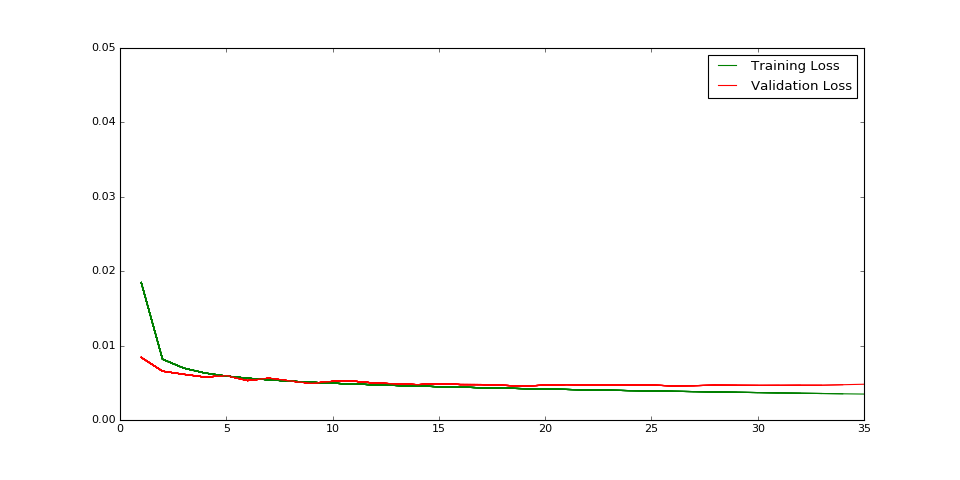

2017-03-28 18:14:22,611 : INFO : Found lower val loss for epoch 1 => 0.00841
2017-03-28 18:14:36,521 : INFO : Found lower val loss for epoch 2 => 0.00656
2017-03-28 18:14:50,700 : INFO : Found lower val loss for epoch 3 => 0.00614
2017-03-28 18:15:04,297 : INFO : Found lower val loss for epoch 4 => 0.00577
2017-03-28 18:15:32,795 : INFO : Found lower val loss for epoch 6 => 0.0053
2017-03-28 18:15:57,387 : INFO : Found lower val loss for epoch 8 => 0.00524
2017-03-28 18:16:11,435 : INFO : Found lower val loss for epoch 9 => 0.00493
2017-03-28 18:17:05,412 : INFO : Found lower val loss for epoch 13 => 0.00486
2017-03-28 18:17:18,409 : INFO : Found lower val loss for epoch 14 => 0.00475
2017-03-28 18:18:11,255 : INFO : Found lower val loss for epoch 18 => 0.00466
2017-03-28 18:18:23,791 : INFO : Found lower val loss for epoch 19 => 0.00457
2017-03-28 18:21:48,604 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00034: early stopping
CPU times: user 3min 40s, sys: 3min 42s, total: 7min 23s
Wall time: 7min 42s


2017-03-28 18:22:06,718 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.279 | Top 3: 0.611 | Top 5: 0.705 | F1 Micro: 0.379 | F1 Macro: 0.068


2017-03-28 18:22:32,175 : INFO : ***************************************************************************************
2017-03-28 18:22:32,178 : INFO : nn_1st-size_500_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           3400500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_122 (Dropout)            (None, 500)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          501000      dropout_122[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


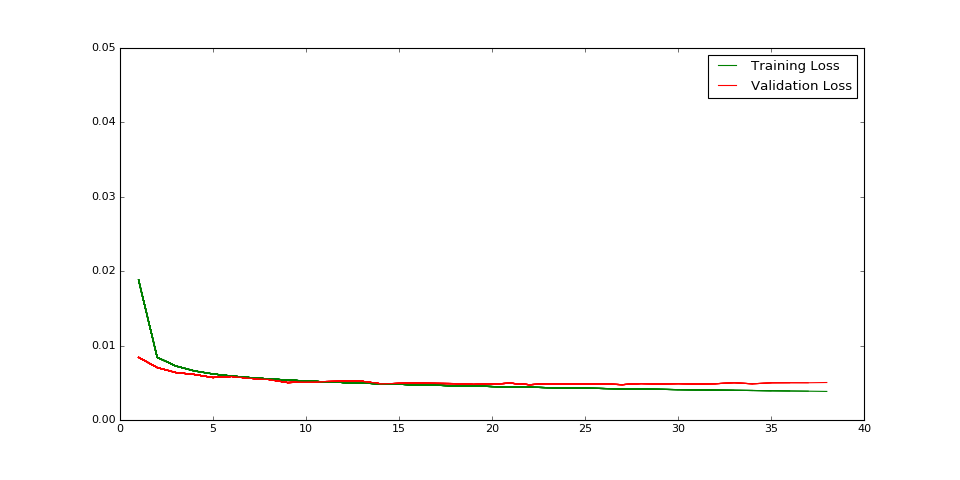

2017-03-28 18:22:42,921 : INFO : Found lower val loss for epoch 1 => 0.00842
2017-03-28 18:22:51,573 : INFO : Found lower val loss for epoch 2 => 0.00705
2017-03-28 18:22:59,067 : INFO : Found lower val loss for epoch 3 => 0.00638
2017-03-28 18:23:08,299 : INFO : Found lower val loss for epoch 4 => 0.00612
2017-03-28 18:23:17,240 : INFO : Found lower val loss for epoch 5 => 0.00571
2017-03-28 18:23:34,427 : INFO : Found lower val loss for epoch 7 => 0.0056
2017-03-28 18:23:43,670 : INFO : Found lower val loss for epoch 8 => 0.00545
2017-03-28 18:23:51,660 : INFO : Found lower val loss for epoch 9 => 0.00503
2017-03-28 18:24:33,333 : INFO : Found lower val loss for epoch 14 => 0.00487
2017-03-28 18:25:17,699 : INFO : Found lower val loss for epoch 19 => 0.00478
2017-03-28 18:25:39,987 : INFO : Found lower val loss for epoch 22 => 0.00475
2017-03-28 18:27:58,770 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00037: early stopping
CPU times: user 3min 1s, sys: 2min 17s, total: 5min 18s
Wall time: 5min 26s


2017-03-28 18:28:12,252 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 14.193 | Top 3: 0.592 | Top 5: 0.686 | F1 Micro: 0.374 | F1 Macro: 0.066


2017-03-28 18:28:38,091 : INFO : ***************************************************************************************
2017-03-28 18:28:38,093 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_123 (Dropout)            (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           94940       dropout_123[0][0]                
Total params: 775040
______________________________________________________________________

<IPython.core.display.Javascript object>


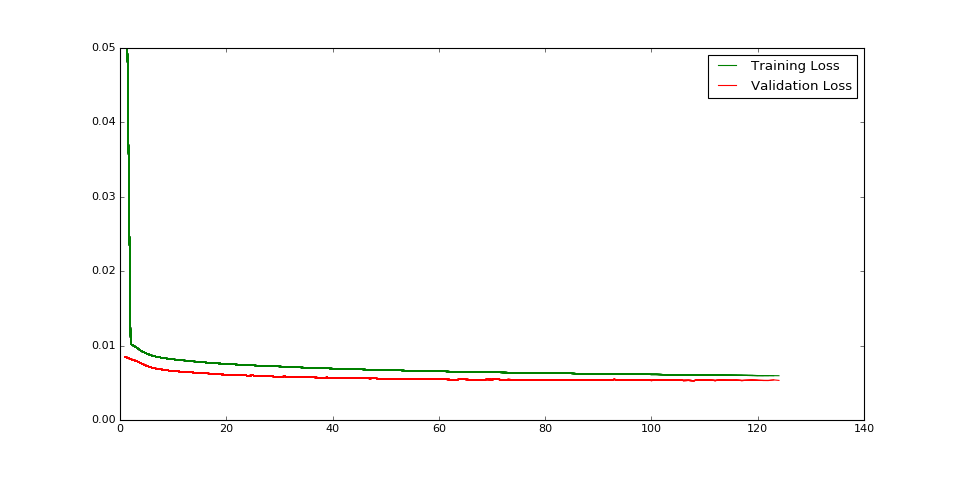

2017-03-28 18:28:46,525 : INFO : Found lower val loss for epoch 1 => 0.00849
2017-03-28 18:28:53,618 : INFO : Found lower val loss for epoch 2 => 0.00818
2017-03-28 18:29:00,366 : INFO : Found lower val loss for epoch 3 => 0.00795
2017-03-28 18:29:06,014 : INFO : Found lower val loss for epoch 4 => 0.00762
2017-03-28 18:29:11,389 : INFO : Found lower val loss for epoch 5 => 0.00728
2017-03-28 18:29:16,865 : INFO : Found lower val loss for epoch 6 => 0.00703
2017-03-28 18:29:22,874 : INFO : Found lower val loss for epoch 7 => 0.00688
2017-03-28 18:29:28,857 : INFO : Found lower val loss for epoch 8 => 0.00678
2017-03-28 18:29:34,110 : INFO : Found lower val loss for epoch 9 => 0.00667
2017-03-28 18:29:39,306 : INFO : Found lower val loss for epoch 10 => 0.00655
2017-03-28 18:29:44,511 : INFO : Found lower val loss for epoch 11 => 0.00653
2017-03-28 18:29:49,716 : INFO : Found lower val loss for epoch 12 => 0.00647
2017-03-28 18:29:55,099 : INFO : Found lower val loss for epoch 13 => 0.0

****** Validation Metrics: Cov Err: 33.075 | Top 3: 0.437 | Top 5: 0.530 | F1 Micro: 0.099 | F1 Macro: 0.002


2017-03-28 18:31:22,671 : INFO : Found lower val loss for epoch 21 => 0.00606
2017-03-28 18:31:28,277 : INFO : Found lower val loss for epoch 22 => 0.00606
2017-03-28 18:31:40,359 : INFO : Found lower val loss for epoch 24 => 0.00596
2017-03-28 18:31:51,695 : INFO : Found lower val loss for epoch 26 => 0.00589
2017-03-28 18:32:07,432 : INFO : Found lower val loss for epoch 29 => 0.00583
2017-03-28 18:32:12,674 : INFO : Found lower val loss for epoch 30 => 0.00581
2017-03-28 18:32:23,893 : INFO : Found lower val loss for epoch 32 => 0.00575
2017-03-28 18:32:29,867 : INFO : Found lower val loss for epoch 33 => 0.00574
2017-03-28 18:32:41,344 : INFO : Found lower val loss for epoch 35 => 0.00573
2017-03-28 18:32:52,002 : INFO : Found lower val loss for epoch 37 => 0.00571
2017-03-28 18:32:57,350 : INFO : Found lower val loss for epoch 38 => 0.00567
2017-03-28 18:33:08,201 : INFO : Found lower val loss for epoch 40 => 0.00561
2017-03-28 18:33:25,759 : INFO : Found lower val loss for epoch 

****** Validation Metrics: Cov Err: 22.487 | Top 3: 0.525 | Top 5: 0.618 | F1 Micro: 0.159 | F1 Macro: 0.008


2017-03-28 18:37:12,212 : INFO : Found lower val loss for epoch 76 => 0.00538
2017-03-28 18:37:17,554 : INFO : Found lower val loss for epoch 77 => 0.00538
2017-03-28 18:37:39,987 : INFO : Found lower val loss for epoch 81 => 0.00537
2017-03-28 18:37:45,799 : INFO : Found lower val loss for epoch 82 => 0.00535
2017-03-28 18:38:13,148 : INFO : Found lower val loss for epoch 87 => 0.00535
2017-03-28 18:38:57,527 : INFO : Found lower val loss for epoch 95 => 0.00534
2017-03-28 18:39:13,504 : INFO : Found lower val loss for epoch 98 => 0.00534
2017-03-28 18:39:24,692 : INFO : Found lower val loss for epoch 100 => 0.00531
2017-03-28 18:39:57,945 : INFO : Found lower val loss for epoch 106 => 0.00531
2017-03-28 18:40:08,606 : INFO : Found lower val loss for epoch 108 => 0.00529
2017-03-28 18:41:37,972 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00123: early stopping
CPU times: user 8min 41s, sys: 4min 40s, total: 13min 22s
Wall time: 12min 59s


2017-03-28 18:41:49,965 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 21.244 | Top 3: 0.546 | Top 5: 0.638 | F1 Micro: 0.174 | F1 Macro: 0.013


2017-03-28 18:42:15,969 : INFO : ***************************************************************************************
2017-03-28 18:42:15,971 : INFO : nn_1st-size_100_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_124 (Dropout)            (None, 100)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           94940       dropout_124[0][0]                
Total params: 775040
______________________________________________________________________

<IPython.core.display.Javascript object>


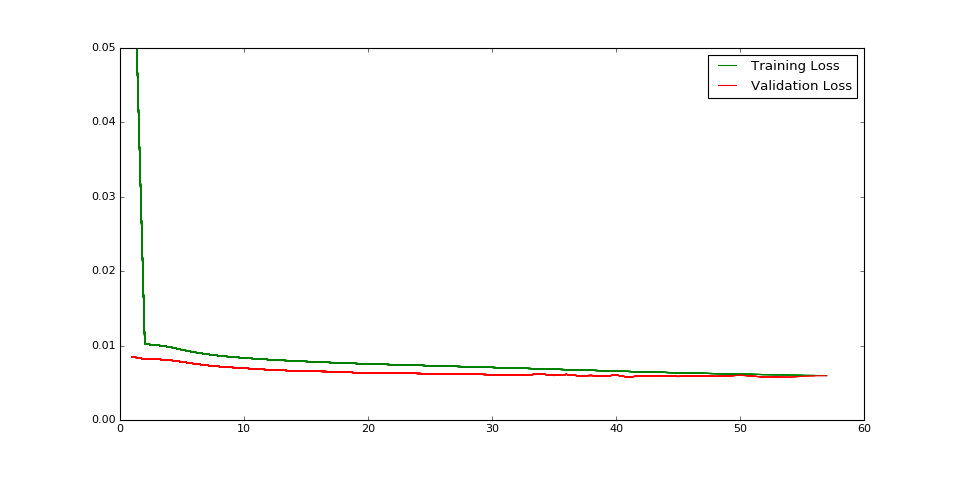

2017-03-28 18:42:24,984 : INFO : Found lower val loss for epoch 1 => 0.00849
2017-03-28 18:42:31,145 : INFO : Found lower val loss for epoch 2 => 0.00819
2017-03-28 18:42:37,483 : INFO : Found lower val loss for epoch 3 => 0.00817
2017-03-28 18:42:42,851 : INFO : Found lower val loss for epoch 4 => 0.00804
2017-03-28 18:42:48,261 : INFO : Found lower val loss for epoch 5 => 0.00782
2017-03-28 18:42:54,281 : INFO : Found lower val loss for epoch 6 => 0.00756
2017-03-28 18:43:00,588 : INFO : Found lower val loss for epoch 7 => 0.00735
2017-03-28 18:43:05,960 : INFO : Found lower val loss for epoch 8 => 0.00719
2017-03-28 18:43:11,262 : INFO : Found lower val loss for epoch 9 => 0.00707
2017-03-28 18:43:16,581 : INFO : Found lower val loss for epoch 10 => 0.00696
2017-03-28 18:43:21,908 : INFO : Found lower val loss for epoch 11 => 0.00685
2017-03-28 18:43:27,459 : INFO : Found lower val loss for epoch 12 => 0.00675
2017-03-28 18:43:33,212 : INFO : Found lower val loss for epoch 13 => 0.0

****** Validation Metrics: Cov Err: 36.800 | Top 3: 0.422 | Top 5: 0.510 | F1 Micro: 0.069 | F1 Macro: 0.001


2017-03-28 18:45:34,330 : INFO : Found lower val loss for epoch 23 => 0.00629
2017-03-28 18:45:47,008 : INFO : Found lower val loss for epoch 24 => 0.00625
2017-03-28 18:45:59,337 : INFO : Found lower val loss for epoch 25 => 0.00622
2017-03-28 18:46:25,557 : INFO : Found lower val loss for epoch 27 => 0.00618
2017-03-28 18:46:38,532 : INFO : Found lower val loss for epoch 28 => 0.00613
2017-03-28 18:47:03,501 : INFO : Found lower val loss for epoch 30 => 0.00609
2017-03-28 18:47:16,879 : INFO : Found lower val loss for epoch 31 => 0.00607
2017-03-28 18:47:30,172 : INFO : Found lower val loss for epoch 32 => 0.00601
2017-03-28 18:48:07,975 : INFO : Found lower val loss for epoch 35 => 0.00599
2017-03-28 18:48:33,248 : INFO : Found lower val loss for epoch 37 => 0.00594
2017-03-28 18:48:58,409 : INFO : Found lower val loss for epoch 39 => 0.00588
2017-03-28 18:49:23,888 : INFO : Found lower val loss for epoch 41 => 0.00575
2017-03-28 18:52:49,500 : INFO : Evaluating on Validation Data u

Epoch 00056: early stopping
CPU times: user 4min 1s, sys: 6min 42s, total: 10min 43s
Wall time: 10min 33s


2017-03-28 18:53:01,929 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 24.283 | Top 3: 0.502 | Top 5: 0.596 | F1 Micro: 0.133 | F1 Macro: 0.004


2017-03-28 18:53:27,745 : INFO : ***************************************************************************************
2017-03-28 18:53:27,747 : INFO : nn_1st-size_1000_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_125 (Dropout)            (None, 1000)          0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 500)           500500      dropout_125[0][0]                
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


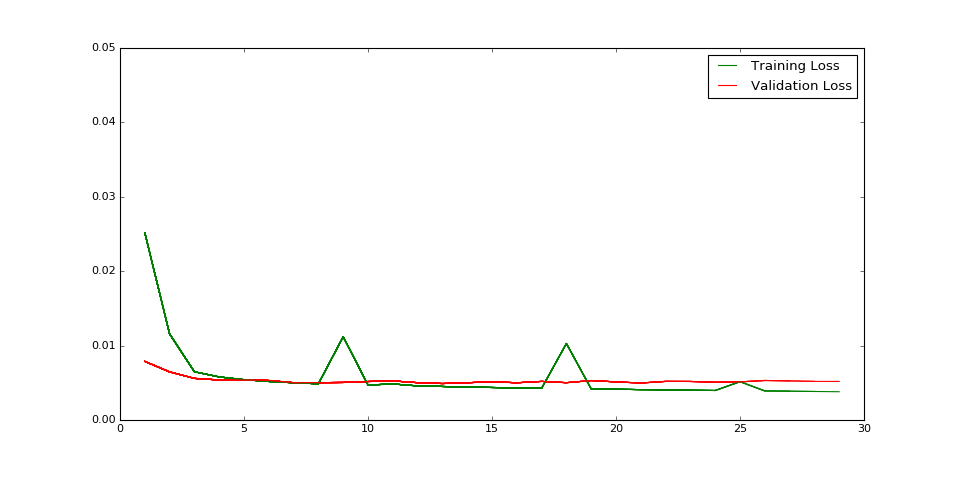

2017-03-28 18:53:39,542 : INFO : Found lower val loss for epoch 1 => 0.00788
2017-03-28 18:53:48,535 : INFO : Found lower val loss for epoch 2 => 0.00647
2017-03-28 18:53:58,265 : INFO : Found lower val loss for epoch 3 => 0.00559
2017-03-28 18:54:07,594 : INFO : Found lower val loss for epoch 4 => 0.00538
2017-03-28 18:54:16,295 : INFO : Found lower val loss for epoch 5 => 0.00537
2017-03-28 18:54:25,575 : INFO : Found lower val loss for epoch 6 => 0.00531
2017-03-28 18:54:34,221 : INFO : Found lower val loss for epoch 7 => 0.00502
2017-03-28 18:55:25,858 : INFO : Found lower val loss for epoch 13 => 0.0049
2017-03-28 18:57:40,437 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00028: early stopping
CPU times: user 1min 57s, sys: 2min 13s, total: 4min 10s
Wall time: 4min 12s


2017-03-28 18:58:03,857 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 16.931 | Top 3: 0.576 | Top 5: 0.668 | F1 Micro: 0.346 | F1 Macro: 0.057


2017-03-28 18:58:26,543 : INFO : ***************************************************************************************
2017-03-28 18:58:26,545 : INFO : nn_1st-size_100_1st-act_relu_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 100)           680100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_126 (Dropout)            (None, 100)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           94940       dropout_126[0][0]                
Total params: 775040
______________________________________________________________________

<IPython.core.display.Javascript object>


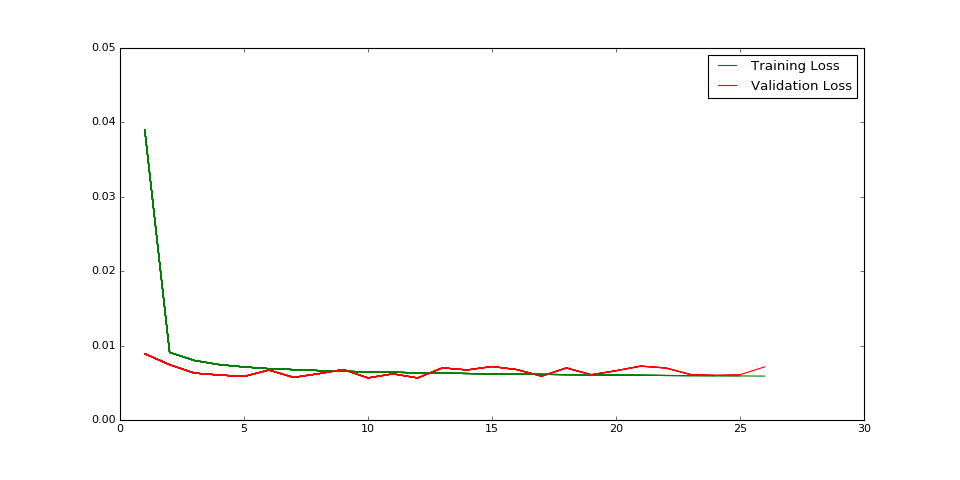

2017-03-28 18:58:35,026 : INFO : Found lower val loss for epoch 1 => 0.00891
2017-03-28 18:58:40,380 : INFO : Found lower val loss for epoch 2 => 0.00743
2017-03-28 18:58:46,410 : INFO : Found lower val loss for epoch 3 => 0.00631
2017-03-28 18:58:51,759 : INFO : Found lower val loss for epoch 4 => 0.00604
2017-03-28 18:58:56,563 : INFO : Found lower val loss for epoch 5 => 0.00585
2017-03-28 18:59:06,769 : INFO : Found lower val loss for epoch 7 => 0.00573
2017-03-28 18:59:22,538 : INFO : Found lower val loss for epoch 10 => 0.00566
2017-03-28 18:59:32,085 : INFO : Found lower val loss for epoch 12 => 0.00565
2017-03-28 19:00:41,163 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00025: early stopping
CPU times: user 1min 47s, sys: 31.5 s, total: 2min 19s
Wall time: 2min 14s


2017-03-28 19:00:52,219 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 19.809 | Top 3: 0.544 | Top 5: 0.639 | F1 Micro: 0.242 | F1 Macro: 0.013


2017-03-28 19:01:15,195 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_subclasses_level_2_batch_2048_nn_parameter_searches.pkl


In [147]:
%matplotlib notebook

param_sampler = ParameterSampler({
    'first_hidden_layer_size':first_hidden_layer_sizes,
    'first_hidden_layer_activation':first_hidden_layer_activations,
    'second_hidden_layer_size':second_hidden_layer_sizes,
    'second_hidden_layer_activation':second_hidden_layer_activations,
    'input_dropout':input_dropout_options,
    'hidden_dropout':hidden_dropout_options,
    'second_hidden_dropout':second_hidden_dropout_options
}, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

param_results_dict = {}

param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))

if load_existing_results:
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
    if os.path.exists(param_results_path):
        info('Loading Previous results in {}'.format(param_results_path))
        param_results_dict = pickle.load(open(param_results_path))
    else:
        info('No Previous results exist in {}'.format(param_results_path))

# create nn parameter search directory
if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
    os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
        
for parameters in param_sampler:
    start_time = time.time()
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']
    second_hidden_dropout_do = parameters['second_hidden_dropout']

    GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    if second_hidden_dropout_do:
        GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue
#         if first_hidden_layer_size < DOC2VEC_SIZE or second_hidden_layer_size < NN_OUTPUT_NEURONS:
#             print "skipping: {} due to 1st layer size {} < {} or 2nd layer size {} < {}".format(GLOBAL_VARS.NN_MODEL_NAME,
#                                                                                                 first_hidden_layer_size, DOC2VEC_SIZE, 
#                                                                                                 second_hidden_layer_size, NN_OUTPUT_NEURONS)
#             continue


    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                  first_hidden_layer_size, first_hidden_layer_activation, 
                                  second_hidden_layer_size, second_hidden_layer_activation, 
                                  input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
    model.summary()

    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()

    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, callbacks=[early_stopper, metrics_callback])


    # using the recorded weights of the best recorded validation loss
    last_model_weights = model.get_weights()
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    time.sleep(0.2)

    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, last_model_weights, metrics_callback

if save_results:
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            loaded_param_results_dict = pickle.load(open(param_results_path))
            param_results_dict.update(loaded_param_results_dict)
            
    pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))


In [51]:
%xdel model
import gc
for i in range(3): gc.collect()

NameError: name 'model' is not defined


In [50]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.2',
 'lstm_optimizer_adam_size_300_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.3_u-drop_0.2',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.2',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.4']

In [51]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

In [52]:
    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
        

In [45]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

In [44]:
%%time
%time yp = model.predict(X)
%time yp_binary = get_binary_0_5(yp)
#print yvp
info('Generating Training Metrics')
training_metrics = get_metrics(y, yp, yp_binary)
print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])

2017-03-09 03:51:31,120 : INFO : Generating Training Metrics


CPU times: user 4min 6s, sys: 1min 35s, total: 5min 41s
Wall time: 5min 41s
CPU times: user 136 ms, sys: 40 ms, total: 176 ms
Wall time: 172 ms


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic

****** Training Metrics: Cov Err: 2.940 | Top 3: 0.705 | Top 5: 0.910 | F1 Micro: 0.000 | F1 Macro: 0.000
CPU times: user 4min 9s, sys: 1min 35s, total: 5min 44s
Wall time: 5min 44s


In [71]:
model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, \
                              nb_epoch=10, verbose=MODEL_VERBOSITY)

Epoch 1/10
20000/20000 [==============================] - 44s - loss: 0.2937    
Epoch 2/10
20000/20000 [==============================] - 44s - loss: 0.2882    
Epoch 3/10
20000/20000 [==============================] - 44s - loss: 0.2843    
Epoch 4/10
20000/20000 [==============================] - 44s - loss: 0.2808    
Epoch 5/10
20000/20000 [==============================] - 44s - loss: 0.2779    
Epoch 6/10
20000/20000 [==============================] - 44s - loss: 0.2743    
Epoch 7/10
20000/20000 [==============================] - 44s - loss: 0.2729    
Epoch 8/10
20000/20000 [==============================] - 44s - loss: 0.2684    
Epoch 9/10
20000/20000 [==============================] - 44s - loss: 0.2687    
Epoch 10/10
20000/20000 [==============================] - 44s - loss: 0.2713    


In [72]:
%%time
%time yp = model.predict(X)
%time yp_binary = get_binary_0_5(yp)
#print yvp
info('Generating Training Metrics')
training_metrics = get_metrics(y, yp, yp_binary)
print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])

2017-03-07 15:30:31,828 : INFO : Generating Training Metrics


CPU times: user 38.9 s, sys: 17.3 s, total: 56.2 s
Wall time: 56.2 s
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 23.7 ms
****** Validation Metrics: Cov Err: 2.181 | Top 3: 0.853 | Top 5: 0.954 | F1 Micro: 0.541 | F1 Macro: 0.403
CPU times: user 39.3 s, sys: 17.3 s, total: 56.7 s
Wall time: 56.6 s


In [73]:
model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, \
                              nb_epoch=20, verbose=MODEL_VERBOSITY)

Epoch 1/20
20000/20000 [==============================] - 44s - loss: 0.2643    
Epoch 2/20
20000/20000 [==============================] - 44s - loss: 0.2611    
Epoch 3/20
20000/20000 [==============================] - 44s - loss: 0.2612    
Epoch 4/20
20000/20000 [==============================] - 44s - loss: 0.2650    
Epoch 5/20
20000/20000 [==============================] - 44s - loss: 0.2597    
Epoch 6/20
20000/20000 [==============================] - 44s - loss: 0.2572    
Epoch 7/20
20000/20000 [==============================] - 44s - loss: 0.2551    
Epoch 8/20
20000/20000 [==============================] - 44s - loss: 0.2519    
Epoch 9/20
20000/20000 [==============================] - 44s - loss: 0.2484    
Epoch 10/20
20000/20000 [==============================] - 44s - loss: 0.2497    
Epoch 11/20
20000/20000 [==============================] - 44s - loss: 0.2501    
Epoch 12/20
20000/20000 [==============================] - 44s - loss: 0.2461    
Epoch 13/20
20000/20000 [

In [74]:
%%time
%time yp = model.predict(X)
%time yp_binary = get_binary_0_5(yp)
#print yvp
info('Generating Training Metrics')
training_metrics = get_metrics(y, yp, yp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])

2017-03-07 16:05:49,006 : INFO : Generating Training Metrics


CPU times: user 38 s, sys: 18.4 s, total: 56.4 s
Wall time: 56.4 s
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.7 ms
****** Validation Metrics: Cov Err: 1.980 | Top 3: 0.887 | Top 5: 0.963 | F1 Micro: 0.628 | F1 Macro: 0.467
CPU times: user 38.4 s, sys: 18.4 s, total: 56.9 s
Wall time: 56.9 s
